# Experiment 2: Raw scan to scan registration

### Goal: use VICET to bound error in LIDAR odometry when initializing LOAM from a moving platform 

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-07-21 13:01:53.335106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 13:01:53.436973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-21 13:01:53.788172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-21 13:01:53.788224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-21 13:01:54.499230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 13:01:54.499398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 13:01:54.499516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 13:01:54.826224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 13:01:54.826400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load HD Map
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [90]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

2023-07-21 14:36:38.348708: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


iter 0
iter 1
iter 2


2023-07-21 14:36:39.006934: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-21 14:36:39.075899: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x70995d0


iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.05135279  0.03857578  0.01863767 -0.00700122  0.0003728  -0.00437663], shape=(6,), dtype=float32)


In [91]:
#put HD Map and new scan in frame of raw keyframe scan
# idx = 2690 #2750 
idx = 2020 #test
skip = 80 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# #remove 4th column and center first scan about origin
# scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
# scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
# submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

5311


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
#run VICET
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.02*np.random.randn(), 0.02*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 100, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 100, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

In [ ]:
#run rigid ICET
it = ICET(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.diff(poses[:,0,3]))
ax.plot(np.diff(poses[:,1,3]))

## Load LOAM Trajectory Initialzied From Moving Platform

In [4]:
# # start at 2400 (corner near tree) very obvious forward motion distortion
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag

# ## start at 2800
# # # rosbag play --clock -s 110.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# LOAM = np.load("results/LOAM/05_LOAM_start_from_2800_v1.npy")
# start_idx = 2810

# # rosbag play --clock -s 100.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
LOAM = np.load("results/LOAM/05_LOAM_start_from_2700_v1.npy")
start_idx = 2400

#  Plot on HD Map

In [66]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

fn = "results/LOAM/05_LOAM_start_from_2700_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2689 #2690

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(0), 0]).as_matrix() #was this for 678
rot_mat = R.from_euler('xyz', [np.deg2rad(10), np.deg2rad(31), np.deg2rad(5.5)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
# gt_lidarframe = (poses[start_idx] @ np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)
# gt_lidarframe = (np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T


gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix() #old
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


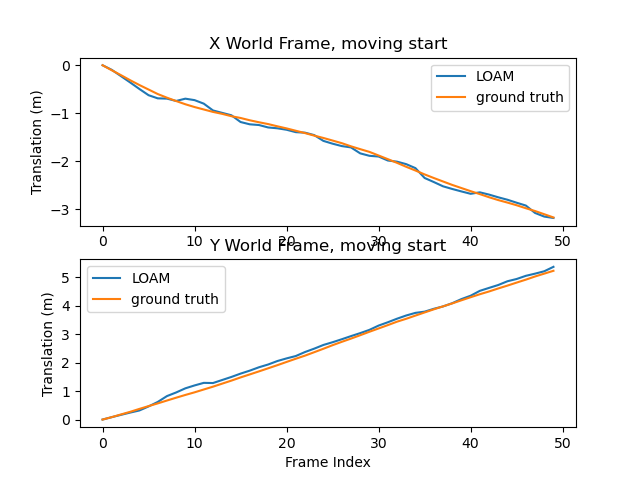

In [67]:
from matplotlib import pyplot as plt

view_len = 50 #ideal
# view_len = 100 #test
# view_len = len(LOAM_corr) #show all data

fig,ax = plt.subplots(2,1)
ax[0].set_title("X World Frame, moving start")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], label = 'ground truth')
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame, moving start")
ax[1].set_ylabel("Translation (m)")
ax[1].set_xlabel("Frame Index")
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM')
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], label = 'ground truth')
ax[1].legend(loc='best')

### Find ~50 frame region where VICET doesn't explode

In [93]:
from linear_corrector import LC #VICET
st = time.time()

runlen = 100 #50
# start_idx = 2700
# start_idx = 1800 #test
start_idx = 2020

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_stds = np.zeros([runlen,12])
X_hist = np.zeros([runlen, 6]) #ICET/ NDT
X_hist_ICP = np.zeros([runlen, 6]) #ICP
raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #9 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    pc1 = np.load(fn1)
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc2 = np.load(fn2)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]

    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
#     submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx+idx] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = pc1, cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 55, niter = 50, draw = False, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A
    VICET_pred_stds[idx,:] = dc.pred_stds
#     np.save("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2", A_hist)


 
 Frame # 2020 at 0.0002779960632324219 sec 
 

A0:
 [-0.0026085   0.01853284  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0013  0.0163 -0.0001  0.     -0.     -0.    ] 
 [ 0.0005 -0.0003  0.0002  0.     -0.      0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0003  0.0143 -0.0002  0.     -0.     -0.    ] 
 [ 0.001  -0.0005  0.0003  0.     -0.      0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0004  0.0125 -0.0002  0.      0.     -0.    ] 
 [ 0.0014 -0.0007  0.0004  0.     -0.      0.0001]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0008  0.0109 -0.0002  0.      0.     -0.    ] 
 [ 0.0017 -0.0009  0.0004  0.     -0.      0.0001]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0011  0.0095 -0.0002  0.      0.     -0.    ] 
 [ 0.002  -0.0011  0.0004  0.     -0.      0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0012  0.0083 -0.0002  0.      0.     -0.    ] 
 [ 0.

A: 
 [ 0.0055  0.0027 -0.0027 -0.0011 -0.0008  0.0001] 
 [-0.0002  0.0106 -0.0136 -0.0028 -0.0011  0.    ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.006   0.0004 -0.003  -0.0011 -0.0008  0.    ] 
 [-0.0008  0.0124 -0.0149 -0.0031 -0.0012  0.0001]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0065 -0.0021 -0.0032 -0.0011 -0.0008 -0.0001] 
 [-0.0017  0.0145 -0.016  -0.0034 -0.0013  0.0002]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0074 -0.0049 -0.0034 -0.0011 -0.0008 -0.0002] 
 [-0.0031  0.0171 -0.0171 -0.0037 -0.0015  0.0005]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0083 -0.0078 -0.0035 -0.0011 -0.0008 -0.0004] 
 [-0.0047  0.0199 -0.018  -0.004  -0.0016  0.0008]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0095 -0.0108 -0.0037 -0.001  -0.0007 -0.0006] 
 [-0.0067  0.023  -0.0188 -0.0043 -0.0017  0.0011]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0106 -0.0137 -0.0039 -0.001  -0.0007 -0.0008] 
 [-0.0087  0.0262 -0.0195 -0.0046 -0.0018  0.0015]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0036  0.0091 -0.0235  0.001  -0.006   0.0001] 
 [-0.0093  0.0032  0.0365  0.0047 -0.0015  0.0011]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0041  0.0094 -0.0235  0.001  -0.0061  0.0001] 
 [-0.0096  0.002   0.0366  0.0048 -0.0015  0.0012]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0044  0.0098 -0.0235  0.001  -0.0061  0.0001] 
 [-0.0099  0.0009  0.0366  0.0048 -0.0015  0.0012]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0047  0.0102 -0.0235  0.001  -0.0061  0.0001] 
 [-0.0102 -0.0003  0.0366  0.0049 -0.0016  0.0013]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0048  0.0106 -0.0234  0.001  -0.0062  0.0001] 
 [-0.0104 -0.0013  0.0365  0.0049 -0.0016  0.0014]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.005   0.011  -0.0233  0.0009 -0.0062  0.    ] 
 [-0.0106 -0.0024  0.0364  0.0049 -0.0016  0.0014]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0051  0.0114 -0.0232  0.0009 -0.0062  0.    ] 
 [-0.0108 -0.0034  0.0362  0.0049 -0.0016  0.0015]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0087  0.0081 -0.0316  0.0031 -0.004   0.0019] 
 [-0.0119  0.0058  0.0407  0.0084 -0.0004  0.001 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0088  0.008  -0.0317  0.0031 -0.004   0.0019] 
 [-0.0121  0.0058  0.0409  0.0085 -0.0003  0.001 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0089  0.0079 -0.0317  0.0031 -0.004   0.002 ] 
 [-0.0122  0.0057  0.0412  0.0086 -0.0003  0.001 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.009   0.0079 -0.0317  0.003  -0.0041  0.002 ] 
 [-0.0124  0.0057  0.0415  0.0086 -0.0003  0.0011]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.009   0.0078 -0.0317  0.003  -0.0041  0.002 ] 
 [-0.0125  0.0057  0.0417  0.0087 -0.0002  0.0011]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0091  0.0078 -0.0317  0.003  -0.0041  0.002 ] 
 [-0.0127  0.0056  0.0419  0.0088 -0.0002  0.0011]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0092  0.0078 -0.0317  0.0029 -0.0041  0.002 ] 
 [-0.0128  0.0056  0.0421  0.0089 -0.0002  0.0011]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.011  -0.004  -0.0194  0.0048 -0.0043  0.0028] 
 [-0.0116  0.0107  0.0306  0.0102  0.0029  0.0008]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0112 -0.0042 -0.0193  0.0047 -0.0044  0.0028] 
 [-0.0117  0.0111  0.031   0.0103  0.003   0.0007]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0114 -0.0044 -0.0192  0.0046 -0.0044  0.0029] 
 [-0.0118  0.0116  0.0315  0.0105  0.003   0.0007]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0115 -0.0046 -0.0192  0.0046 -0.0045  0.0029] 
 [-0.0119  0.012   0.0319  0.0107  0.0031  0.0007]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0117 -0.0048 -0.0191  0.0045 -0.0046  0.0029] 
 [-0.012   0.0124  0.0324  0.0108  0.0032  0.0006]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0119 -0.0051 -0.0191  0.0045 -0.0046  0.003 ] 
 [-0.0121  0.0128  0.0328  0.011   0.0033  0.0006]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0121 -0.0053 -0.019   0.0044 -0.0047  0.003 ] 
 [-0.0122  0.0132  0.0332  0.0111  0.0034  0.0006]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0066  0.029   0.006   0.0047 -0.0019  0.0005] 
 [-0.0287 -0.0405 -0.0212  0.0051  0.0034  0.0051]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0064  0.0296  0.0062  0.0047 -0.0019  0.0005] 
 [-0.0288 -0.0416 -0.0212  0.0052  0.0034  0.0052]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0063  0.0302  0.0064  0.0047 -0.0019  0.0004] 
 [-0.0288 -0.0428 -0.0212  0.0053  0.0034  0.0053]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0062  0.0308  0.0066  0.0046 -0.0019  0.0004] 
 [-0.0288 -0.0439 -0.0211  0.0054  0.0034  0.0054]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.006   0.0314  0.0068  0.0046 -0.002   0.0003] 
 [-0.0289 -0.045  -0.0211  0.0055  0.0035  0.0054]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0059  0.032   0.0069  0.0045 -0.002   0.0003] 
 [-0.0289 -0.0461 -0.0211  0.0055  0.0035  0.0055]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0057  0.0325  0.0071  0.0045 -0.002   0.0002] 
 [-0.0289 -0.0471 -0.0211  0.0056  0.0035  0.0056]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [ 0.0358 -0.0118  0.0201  0.0062 -0.0039  0.0033] 
 [-0.0324  0.0307 -0.0205  0.0126  0.006   0.0126]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0357 -0.0114  0.0202  0.0062 -0.0039  0.0033] 
 [-0.0325  0.0301 -0.0205  0.0127  0.006   0.0126]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0356 -0.0111  0.0202  0.0062 -0.0039  0.0032] 
 [-0.0327  0.0295 -0.0204  0.0127  0.0061  0.0127]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0356 -0.0108  0.0202  0.0061 -0.0039  0.0032] 
 [-0.0328  0.0289 -0.0203  0.0127  0.0061  0.0127]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0355 -0.0105  0.0201  0.0061 -0.0039  0.0032] 
 [-0.033   0.0283 -0.0202  0.0127  0.0061  0.0128]

 
 Frame # 2027 at 39.51893973350525 sec 
 

A0:
 [-0.00894781 -0.0083629   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0054 -0.0052 -0.0017  0.0022 -0.001   0.0002] 
 [-0.0056  0.0018  0.0035  0.0016  0.002

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0005 -0.0144 -0.      0.0016 -0.0012  0.0008] 
 [-0.0035  0.0149 -0.0017  0.0022  0.0012  0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0023 -0.0174 -0.      0.0026 -0.0023  0.0015] 
 [-0.0073  0.0277 -0.0016  0.0045  0.0024  0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0056 -0.0197  0.0007  0.0033 -0.0033  0.0021] 
 [-0.011   0.038  -0.0022  0.0068  0.0033  0.0007]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0092 -0.0212  0.0018  0.0037 -0.0041  0.0026] 
 [-0.0148  0.0453 -0.0029  0.0088  0.0041  0.0011]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0128 -0.0222  0.0032  0.0039 -0.0048  0.003 ] 
 [-0.0183  0.0508 -0.004   0.0105  0.0048  0.0015]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0164 -0.0227  0.0046  0.0041 -0.0053  0.0033] 
 [-0.0216  0.0551 -0.0051  0.012   0.0053  0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0199 -0.0227  0.006   0.0041 -0.0058  0.0036] 
 [-0.0248  0.0576 -0.0063  0.0132  0.0057  0.0024]
~~~~~~

A: 
 [ 0.0306 -0.0168 -0.0171  0.0048 -0.0049  0.0035] 
 [-0.0374  0.0461  0.0304  0.0102  0.0048  0.0055]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0328 -0.0179 -0.0172  0.0048 -0.0053  0.0039] 
 [-0.0397  0.05    0.0321  0.0112  0.0052  0.0061]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0347 -0.0191 -0.0172  0.0048 -0.0057  0.0042] 
 [-0.0415  0.0533  0.0335  0.0122  0.0056  0.0066]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0363 -0.0201 -0.0172  0.0047 -0.006   0.0044] 
 [-0.0428  0.0559  0.0348  0.0129  0.0059  0.0071]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0378 -0.0211 -0.0169  0.0047 -0.0063  0.0047] 
 [-0.0437  0.058   0.0357  0.0136  0.0062  0.0075]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0389 -0.022  -0.0166  0.0046 -0.0065  0.0049] 
 [-0.0443  0.0596  0.0363  0.0142  0.0064  0.0079]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0399 -0.0229 -0.016   0.0044 -0.0067  0.005 ] 
 [-0.0446  0.0609  0.0366  0.0148  0.0066  0.0083]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A:

A: 
 [ 0.0339  0.0055 -0.0016  0.0055 -0.0044  0.0039] 
 [-0.0375  0.019   0.0028  0.0069  0.003   0.0069]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0347  0.0061 -0.0013  0.0055 -0.0045  0.0039] 
 [-0.0387  0.0165  0.0032  0.0072  0.0031  0.0073]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0352  0.0065 -0.001   0.0054 -0.0046  0.0039] 
 [-0.0398  0.014   0.0036  0.0075  0.0032  0.0078]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0356  0.0069 -0.0007  0.0053 -0.0047  0.0038] 
 [-0.0408  0.0116  0.0039  0.0077  0.0033  0.0082]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0358  0.0073 -0.0004  0.0053 -0.0048  0.0038] 
 [-0.0415  0.0094  0.0042  0.008   0.0034  0.0085]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0358  0.0076 -0.0001  0.0052 -0.0049  0.0037] 
 [-0.0422  0.0073  0.0045  0.0082  0.0034  0.0089]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0357  0.0078  0.0001  0.0051 -0.0049  0.0037] 
 [-0.0427  0.0054  0.0048  0.0084  0.0035  0.0092]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0136 -0.0231 -0.008   0.0062 -0.0027  0.0033] 
 [-0.0124  0.0477  0.0133  0.0054  0.0021  0.0064]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0135 -0.0233 -0.0078  0.0062 -0.0028  0.0034] 
 [-0.0126  0.0467  0.0133  0.0056  0.0021  0.0064]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0134 -0.0235 -0.0075  0.0061 -0.0028  0.0034] 
 [-0.0129  0.0456  0.0133  0.0057  0.0022  0.0065]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0134 -0.0235 -0.0073  0.006  -0.0029  0.0034] 
 [-0.0132  0.0445  0.0133  0.0058  0.0023  0.0065]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0133 -0.0236 -0.007   0.006  -0.0029  0.0034] 
 [-0.0135  0.0434  0.0133  0.006   0.0023  0.0065]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0132 -0.0235 -0.0068  0.0059 -0.003   0.0034] 
 [-0.0138  0.0423  0.0133  0.0061  0.0024  0.0066]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0131 -0.0235 -0.0066  0.0059 -0.003   0.0034] 
 [-0.0141  0.0412  0.0133  0.0062  0.0024  0.0066]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.0069 -0.0085  0.0053  0.0036 -0.0055  0.0019] 
 [-0.016   0.0137  0.0092  0.0093  0.0053  0.0043]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.007  -0.008   0.0054  0.0036 -0.0055  0.0019] 
 [-0.0165  0.0126  0.0094  0.0094  0.0053  0.0044]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0072 -0.0075  0.0054  0.0036 -0.0055  0.0019] 
 [-0.0169  0.0116  0.0095  0.0094  0.0054  0.0044]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0073 -0.0071  0.0054  0.0036 -0.0055  0.0019] 
 [-0.0173  0.0106  0.0097  0.0095  0.0054  0.0045]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0074 -0.0066  0.0054  0.0035 -0.0056  0.0019] 
 [-0.0177  0.0097  0.0098  0.0095  0.0054  0.0045]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0075 -0.0061  0.0054  0.0035 -0.0056  0.0019] 
 [-0.0181  0.0088  0.0099  0.0095  0.0054  0.0046]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0076 -0.0057  0.0054  0.0035 -0.0056  0.0018] 
 [-0.0185  0.008   0.0101  0.0095  0.0055  0.0046]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0258  0.004   0.0255  0.0042 -0.0033  0.0007] 
 [-0.0443 -0.001  -0.0215  0.0114  0.0028  0.0082]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0257  0.0042  0.0256  0.0042 -0.0033  0.0007] 
 [-0.0444 -0.0013 -0.0217  0.0114  0.0027  0.0083]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0256  0.0043  0.0257  0.0042 -0.0033  0.0007] 
 [-0.0444 -0.0016 -0.0219  0.0114  0.0027  0.0084]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0255  0.0044  0.0258  0.0042 -0.0033  0.0006] 
 [-0.0444 -0.0019 -0.022   0.0114  0.0027  0.0085]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0254  0.0046  0.0259  0.0042 -0.0033  0.0006] 
 [-0.0444 -0.0021 -0.0222  0.0114  0.0027  0.0086]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0252  0.0047  0.0259  0.0042 -0.0033  0.0006] 
 [-0.0443 -0.0024 -0.0223  0.0114  0.0027  0.0087]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0251  0.0049  0.026   0.0042 -0.0033  0.0005] 
 [-0.0443 -0.0027 -0.0224  0.0114  0.0027  0.0087]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [ 0.0084  0.0036 -0.0089  0.0061 -0.0043  0.0023] 
 [-0.0252 -0.0122  0.0304  0.0094  0.0116  0.0028]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0085  0.0037 -0.009   0.006  -0.0044  0.0023] 
 [-0.0253 -0.0123  0.0313  0.0096  0.0117  0.0028]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0085  0.0038 -0.0091  0.006  -0.0045  0.0023] 
 [-0.0254 -0.0123  0.0322  0.0098  0.0117  0.0028]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0086  0.0039 -0.0093  0.0059 -0.0045  0.0023] 
 [-0.0255 -0.0124  0.033   0.0099  0.0118  0.0028]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0087  0.004  -0.0094  0.0059 -0.0046  0.0023] 
 [-0.0257 -0.0125  0.0339  0.0101  0.0119  0.0028]

 
 Frame # 2035 at 87.98206377029419 sec 
 

A0:
 [ 0.00551427 -0.00336662  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0072 -0.0053  0.0018  0.0016 -0.0002  0.0004] 
 [-0.0044  0.0077 -0.0057  0.0001  0.000

A: 
 [ 0.0085  0.0111  0.0023  0.0035 -0.      0.0002] 
 [-0.0034  0.0036 -0.0053  0.0002  0.0005  0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0086  0.0109  0.0034  0.0046 -0.0001  0.0003] 
 [-0.0048  0.0049 -0.0074  0.0004  0.0008  0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0086  0.0105  0.0044  0.0055 -0.0001  0.0004] 
 [-0.0062  0.006  -0.0094  0.0007  0.001   0.0052]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0087  0.0101  0.0053  0.0062 -0.0002  0.0004] 
 [-0.0073  0.0066 -0.0109  0.0009  0.0011  0.0063]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0087  0.0095  0.0063  0.0066 -0.0002  0.0004] 
 [-0.0081  0.007  -0.0123  0.0013  0.0013  0.0074]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0089  0.009   0.0072  0.007  -0.0003  0.0004] 
 [-0.0089  0.007  -0.0133  0.0016  0.0015  0.0084]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0091  0.0084  0.0081  0.0072 -0.0004  0.0004] 
 [-0.0097  0.0067 -0.0143  0.0019  0.0016  0.0093]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.016  -0.0023  0.0065  0.0053 -0.0053  0.0017] 
 [-0.0315  0.0056  0.0102  0.0097  0.0102  0.0048]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.017  -0.0022  0.0066  0.0053 -0.0055  0.0018] 
 [-0.0332  0.0062  0.0112  0.0101  0.0106  0.0051]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.018  -0.0021  0.0067  0.0054 -0.0056  0.0018] 
 [-0.0348  0.0067  0.0121  0.0105  0.0109  0.0054]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.019  -0.0022  0.0068  0.0054 -0.0058  0.0019] 
 [-0.0362  0.0072  0.0127  0.0108  0.0111  0.0056]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0199 -0.0022  0.0069  0.0054 -0.0059  0.0019] 
 [-0.0376  0.0076  0.0133  0.011   0.0113  0.0059]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0208 -0.0024  0.007   0.0054 -0.006   0.0019] 
 [-0.0388  0.0081  0.0136  0.0112  0.0114  0.0061]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0216 -0.0025  0.0072  0.0054 -0.0061  0.002 ] 
 [-0.0399  0.0085  0.0139  0.0114  0.0115  0.0064]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.0413  0.004   0.0089  0.0055 -0.0038  0.0049] 
 [-0.0424  0.0141 -0.0068  0.0099  0.0063  0.0121]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0419  0.0047  0.0095  0.0054 -0.0039  0.0048] 
 [-0.0439  0.0106 -0.0068  0.0101  0.0065  0.0126]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0424  0.0054  0.0101  0.0053 -0.004   0.0047] 
 [-0.0453  0.0071 -0.0068  0.0104  0.0066  0.0131]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0427  0.0061  0.0106  0.0051 -0.0041  0.0046] 
 [-0.0466  0.0038 -0.0068  0.0107  0.0067  0.0135]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0429  0.0067  0.0111  0.005  -0.0042  0.0045] 
 [-0.0478  0.0008 -0.0068  0.0109  0.0068  0.0139]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.043   0.0072  0.0116  0.0049 -0.0043  0.0044] 
 [-0.049  -0.0019 -0.0068  0.0111  0.0069  0.0143]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.043   0.0076  0.0121  0.0049 -0.0043  0.0043] 
 [-0.05   -0.0044 -0.0069  0.0113  0.007   0.0146]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [ 0.031  -0.0089  0.0084  0.0034 -0.0047  0.0033] 
 [-0.0276  0.0335  0.0195  0.0162  0.0087  0.0109]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0312 -0.0093  0.0084  0.0034 -0.0047  0.0033] 
 [-0.0283  0.0333  0.0195  0.0161  0.0088  0.0111]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0315 -0.0098  0.0084  0.0034 -0.0047  0.0033] 
 [-0.029   0.033   0.0195  0.0161  0.0088  0.0113]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0317 -0.0102  0.0084  0.0034 -0.0047  0.0033] 
 [-0.0298  0.0327  0.0194  0.0161  0.0088  0.0115]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.0319 -0.0105  0.0084  0.0034 -0.0047  0.0033] 
 [-0.0306  0.0323  0.0194  0.016   0.0088  0.0117]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0322 -0.0108  0.0084  0.0034 -0.0047  0.0033] 
 [-0.0315  0.0319  0.0193  0.016   0.0088  0.0119]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0325 -0.0111  0.0085  0.0034 -0.0047  0.0033] 
 [-0.0323  0.0315  0.0192  0.016   0.0088  0.0121]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [ 0.0323 -0.0151  0.0085  0.0062 -0.0042  0.0038] 
 [-0.0454  0.0177  0.0162  0.0095  0.0102  0.0074]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0324 -0.0146  0.0086  0.0062 -0.0042  0.0038] 
 [-0.0458  0.0168  0.0161  0.0095  0.0102  0.0075]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0325 -0.0142  0.0087  0.0062 -0.0042  0.0038] 
 [-0.0462  0.0159  0.016   0.0095  0.0102  0.0075]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0326 -0.0137  0.0087  0.0062 -0.0042  0.0037] 
 [-0.0465  0.015   0.0159  0.0096  0.0102  0.0076]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0327 -0.0132  0.0088  0.0062 -0.0042  0.0037] 
 [-0.0469  0.0141  0.0158  0.0096  0.0102  0.0077]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0327 -0.0128  0.0089  0.0062 -0.0042  0.0037] 
 [-0.0472  0.0132  0.0157  0.0096  0.0102  0.0077]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0328 -0.0123  0.009   0.0062 -0.0042  0.0036] 
 [-0.0475  0.0124  0.0156  0.0096  0.0102  0.0078]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [ 0.0368  0.027  -0.0049  0.0061 -0.0054 -0.0004] 
 [-0.0653 -0.0471  0.0404  0.0079  0.0151  0.0222]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0357  0.0268 -0.005   0.0061 -0.0054 -0.0005] 
 [-0.0645 -0.0474  0.0409  0.0079  0.0151  0.0224]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0346  0.0267 -0.0051  0.0061 -0.0055 -0.0006] 
 [-0.0637 -0.0476  0.0414  0.008   0.0152  0.0227]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0335  0.0266 -0.0052  0.0061 -0.0055 -0.0008] 
 [-0.0628 -0.0478  0.0418  0.0081  0.0153  0.0229]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0323  0.0264 -0.0053  0.006  -0.0056 -0.0009] 
 [-0.0618 -0.0479  0.0422  0.0081  0.0153  0.0232]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0312  0.0263 -0.0054  0.006  -0.0056 -0.001 ] 
 [-0.0609 -0.0481  0.0426  0.0082  0.0154  0.0234]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0301  0.0262 -0.0055  0.006  -0.0056 -0.0011] 
 [-0.0599 -0.0482  0.043   0.0082  0.0155  0.0236]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

A: 
 [ 0.0536 -0.021   0.0061  0.0058 -0.0019  0.0067] 
 [-0.0479  0.0246 -0.003   0.0048  0.0066  0.0225]

 
 Frame # 2043 at 139.609112739563 sec 
 

A0:
 [0.01448101 0.01266954 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.021   0.0112  0.0027  0.0015 -0.0001  0.0006] 
 [-0.0115  0.0063 -0.0042  0.0003  0.0007  0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0271  0.0096  0.005   0.0025 -0.0002  0.0011] 
 [-0.0218  0.011  -0.0074  0.0007  0.0014  0.0028]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0326  0.0078  0.0069  0.0033 -0.0004  0.0016] 
 [-0.0306  0.015  -0.0097  0.0011  0.0019  0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0376  0.0058  0.0086  0.0039 -0.0006  0.0021] 
 [-0.0384  0.0186 -0.0113  0.0016  0.0024  0.0052]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.042   0.0038  0.01    0.0043 -0.0007  0.0026] 
 [-0.045   0.0217 -0.0124  0.0021  0.0029  0.0062]
~~~~~~

A: 
 [ 0.0412 -0.0256 -0.0021  0.0069 -0.0003  0.0034] 
 [-0.0529  0.0748 -0.0105 -0.0008  0.0018  0.0058]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.047  -0.0268 -0.0023  0.0073 -0.0004  0.0039] 
 [-0.0588  0.0827 -0.0108 -0.0007  0.002   0.0065]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0525 -0.0279 -0.0024  0.0076 -0.0005  0.0043] 
 [-0.064   0.0892 -0.011  -0.0006  0.0022  0.0072]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0575 -0.0288 -0.0025  0.0078 -0.0006  0.0047] 
 [-0.0685  0.0945 -0.011  -0.0005  0.0024  0.0078]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0622 -0.0296 -0.0025  0.008  -0.0007  0.0051] 
 [-0.0725  0.0987 -0.0109 -0.0004  0.0025  0.0083]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0665 -0.0303 -0.0025  0.0081 -0.0008  0.0055] 
 [-0.076   0.1019 -0.0109 -0.0003  0.0026  0.0088]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0702 -0.0306 -0.0025  0.0082 -0.0008  0.0058] 
 [-0.079   0.1038 -0.0109 -0.0002  0.0028  0.0093]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0663  0.0057 -0.0088  0.0064 -0.0009  0.0032] 
 [-0.0613  0.0457 -0.0038  0.0016  0.0024  0.0177]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0664  0.0089 -0.0086  0.0064 -0.0009  0.0031] 
 [-0.0609  0.0365 -0.0037  0.0018  0.0025  0.0186]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0661  0.0118 -0.0083  0.0064 -0.001   0.0029] 
 [-0.0605  0.0275 -0.0037  0.0019  0.0025  0.0195]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0658  0.0145 -0.0081  0.0063 -0.001   0.0028] 
 [-0.0603  0.0192 -0.0036  0.002   0.0026  0.0202]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0654  0.0169 -0.0078  0.0063 -0.0011  0.0027] 
 [-0.0603  0.0113 -0.0036  0.0021  0.0026  0.0208]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0649  0.0191 -0.0075  0.0063 -0.0011  0.0027] 
 [-0.0603  0.0039 -0.0036  0.0023  0.0027  0.0214]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0644  0.021  -0.0072  0.0062 -0.0011  0.0026] 
 [-0.0605 -0.0028 -0.0037  0.0023  0.0028  0.0219]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0556 -0.0025 -0.0006  0.0068 -0.0016  0.0057] 
 [-0.055   0.0108 -0.0071  0.0039  0.0016  0.0041]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0561 -0.0019 -0.0003  0.0067 -0.0016  0.0057] 
 [-0.0565  0.0085 -0.0072  0.0041  0.0017  0.0042]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0566 -0.0013  0.0001  0.0067 -0.0016  0.0057] 
 [-0.0578  0.0063 -0.0073  0.0042  0.0017  0.0044]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.057  -0.0008  0.0004  0.0066 -0.0017  0.0057] 
 [-0.0591  0.0042 -0.0074  0.0043  0.0018  0.0046]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0573 -0.0002  0.0007  0.0065 -0.0017  0.0057] 
 [-0.0603  0.0022 -0.0075  0.0045  0.0018  0.0048]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0576  0.0003  0.001   0.0065 -0.0018  0.0057] 
 [-0.0615  0.0004 -0.0076  0.0046  0.0018  0.0049]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0579  0.0008  0.0014  0.0064 -0.0018  0.0057] 
 [-0.0625 -0.0013 -0.0077  0.0048  0.0019  0.0051]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.0474  0.0324 -0.0072  0.0046 -0.0027  0.0007] 
 [-0.0569 -0.046   0.0138  0.0045  0.0054  0.008 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0479  0.0331 -0.0072  0.0045 -0.0028  0.0007] 
 [-0.0581 -0.0474  0.0144  0.0046  0.0055  0.008 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0483  0.0336 -0.0072  0.0045 -0.0029  0.0008] 
 [-0.0592 -0.0488  0.0149  0.0047  0.0056  0.008 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0487  0.0342 -0.0073  0.0044 -0.0029  0.0008] 
 [-0.0603 -0.0501  0.0154  0.0049  0.0057  0.0081]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0492  0.0348 -0.0073  0.0044 -0.003   0.0008] 
 [-0.0613 -0.0514  0.016   0.005   0.0058  0.0081]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0496  0.0353 -0.0073  0.0043 -0.0031  0.0008] 
 [-0.0624 -0.0526  0.0165  0.0051  0.0059  0.0081]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.05    0.0358 -0.0073  0.0043 -0.0032  0.0008] 
 [-0.0634 -0.0537  0.017   0.0053  0.0061  0.0082]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0635  0.0505  0.0248  0.0035 -0.0003  0.0002] 
 [-0.0835 -0.0733 -0.0342  0.0035  0.0025  0.0173]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0631  0.0513  0.0251  0.0035 -0.0003  0.0001] 
 [-0.0835 -0.0747 -0.0344  0.0036  0.0025  0.0174]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0627  0.0521  0.0254  0.0034 -0.0003 -0.    ] 
 [-0.0835 -0.0759 -0.0346  0.0037  0.0025  0.0176]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0623  0.0528  0.0256  0.0034 -0.0003 -0.0001] 
 [-0.0835 -0.0771 -0.0348  0.0038  0.0025  0.0177]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.062   0.0535  0.0259  0.0033 -0.0004 -0.0002] 
 [-0.0834 -0.0782 -0.0349  0.0039  0.0025  0.0178]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0616  0.0542  0.0261  0.0033 -0.0004 -0.0002] 
 [-0.0833 -0.0793 -0.0351  0.004   0.0025  0.0179]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0613  0.0548  0.0264  0.0032 -0.0004 -0.0003] 
 [-0.0832 -0.0802 -0.0352  0.0041  0.0025  0.018 ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [ 0.0538 -0.0098 -0.0038  0.0032 -0.0042  0.0061] 
 [-0.051   0.0176  0.0315  0.0095  0.0086 -0.0012]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.054  -0.0098 -0.0037  0.0032 -0.0042  0.0062] 
 [-0.0514  0.0175  0.0315  0.0095  0.0086 -0.0012]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0543 -0.0099 -0.0037  0.0032 -0.0042  0.0062] 
 [-0.0518  0.0174  0.0314  0.0095  0.0086 -0.0013]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0545 -0.0099 -0.0037  0.0032 -0.0042  0.0062] 
 [-0.0522  0.0174  0.0314  0.0095  0.0086 -0.0013]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0548 -0.0099 -0.0037  0.0032 -0.0042  0.0063] 
 [-0.0526  0.0173  0.0313  0.0095  0.0086 -0.0013]

 
 Frame # 2050 at 186.5836842060089 sec 
 

A0:
 [0.01952723 0.00657375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0197  0.0107  0.001   0.0016 -0.0003  0.0001] 
 [-0.0003 -0.01   -0.0035 -0.0001  0.0006 -0.0002]
~

A: 
 [ 0.0183  0.0005  0.0014  0.0017 -0.0013  0.0003] 
 [-0.0155  0.0033  0.0027  0.0037  0.0028  0.0013]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0244  0.0022  0.0018  0.0023 -0.0018  0.0004] 
 [-0.0221  0.0035  0.0045  0.0052  0.0039  0.0018]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0298  0.0039  0.0021  0.0026 -0.0023  0.0005] 
 [-0.0281  0.0033  0.0065  0.0065  0.0049  0.0024]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0348  0.006   0.0022  0.0029 -0.0027  0.0006] 
 [-0.0335  0.002   0.0084  0.0076  0.0057  0.0028]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0394  0.0081  0.0022  0.0031 -0.0031  0.0007] 
 [-0.0386  0.0004  0.0105  0.0086  0.0063  0.0033]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0435  0.0101  0.0022  0.0033 -0.0034  0.0007] 
 [-0.0431 -0.0018  0.0123  0.0094  0.0069  0.0037]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0472  0.0122  0.0021  0.0034 -0.0036  0.0007] 
 [-0.0471 -0.0047  0.014   0.01    0.0074  0.0041]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.0273  0.0274  0.0099  0.0092  0.0022 -0.0002] 
 [-0.0189 -0.0449 -0.0304 -0.0016  0.0036  0.002 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0277  0.028   0.01    0.0094  0.0022 -0.0002] 
 [-0.0197 -0.0468 -0.0309 -0.0016  0.0037  0.002 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.028   0.0286  0.0101  0.0095  0.0022 -0.0001] 
 [-0.0204 -0.0484 -0.0313 -0.0015  0.0038  0.0021]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0283  0.0291  0.0102  0.0097  0.0022 -0.0001] 
 [-0.0211 -0.0499 -0.0315 -0.0015  0.0039  0.0021]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0285  0.0295  0.0103  0.0097  0.0022 -0.0001] 
 [-0.0217 -0.0511 -0.0316 -0.0014  0.004   0.0021]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0287  0.0299  0.0103  0.0098  0.0022 -0.0001] 
 [-0.0223 -0.0523 -0.0317 -0.0014  0.004   0.0021]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0289  0.0303  0.0104  0.0098  0.0022 -0.0001] 
 [-0.0229 -0.0534 -0.0316 -0.0013  0.0041  0.0021]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [0.0555 0.0584 0.0298 0.0053 0.0016 0.0005] 
 [-0.0639 -0.0747 -0.0539 -0.0008  0.0059  0.013 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [0.0563 0.0608 0.0302 0.0053 0.0016 0.0005] 
 [-0.0658 -0.0802 -0.0541 -0.0007  0.006   0.0132]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [0.0571 0.063  0.0305 0.0052 0.0016 0.0004] 
 [-0.0676 -0.0852 -0.0544 -0.0006  0.006   0.0134]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [0.0577 0.065  0.0308 0.0052 0.0016 0.0004] 
 [-0.0693 -0.0896 -0.0545 -0.0006  0.006   0.0135]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [0.0583 0.0668 0.031  0.0052 0.0016 0.0004] 
 [-0.071  -0.0935 -0.0547 -0.0005  0.0061  0.0137]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [0.0588 0.0684 0.0313 0.0051 0.0016 0.0003] 
 [-0.0725 -0.0969 -0.0548 -0.0004  0.0061  0.0138]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [0.0593 0.0698 0.0315 0.0051 0.0015 0.0003] 
 [-0.074  -0.0999 -0.0549 -0.0004  0.0061  0.0139]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [0.0598 0.0711 0.0317 0.0051 0.0015 

A: 
 [ 0.0788  0.003   0.0234  0.0029 -0.0013  0.0039] 
 [-0.0387  0.0597 -0.0275  0.0027  0.0053  0.0282]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0777  0.0032  0.0236  0.0029 -0.0013  0.0039] 
 [-0.0373  0.0568 -0.0276  0.0028  0.0054  0.0286]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0766  0.0035  0.0238  0.0028 -0.0013  0.0038] 
 [-0.036   0.0538 -0.0277  0.0029  0.0054  0.0289]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0754  0.0039  0.024   0.0028 -0.0013  0.0038] 
 [-0.0348  0.0508 -0.0277  0.0029  0.0054  0.0292]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.0743  0.0044  0.0242  0.0027 -0.0014  0.0038] 
 [-0.0337  0.0478 -0.0278  0.0029  0.0054  0.0295]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0732  0.0049  0.0244  0.0027 -0.0014  0.0037] 
 [-0.0327  0.0447 -0.0279  0.003   0.0054  0.0298]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0721  0.0056  0.0245  0.0027 -0.0014  0.0037] 
 [-0.0318  0.0417 -0.028   0.003   0.0055  0.03  ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [0.059  0.0267 0.0173 0.0055 0.0019 0.0063] 
 [-0.0352 -0.0097 -0.0347 -0.0013  0.0017  0.0056]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [0.0589 0.0268 0.0175 0.0054 0.0019 0.0063] 
 [-0.0355 -0.0102 -0.035  -0.0012  0.0017  0.0057]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [0.0588 0.0268 0.0178 0.0054 0.0019 0.0063] 
 [-0.0358 -0.0106 -0.0352 -0.0011  0.0017  0.0058]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [0.0586 0.0268 0.018  0.0053 0.0019 0.0063] 
 [-0.0361 -0.0109 -0.0355 -0.0011  0.0017  0.0058]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [0.0585 0.0268 0.0183 0.0053 0.0019 0.0063] 
 [-0.0363 -0.0112 -0.0357 -0.001   0.0017  0.0059]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [0.0584 0.0268 0.0185 0.0053 0.0019 0.0063] 
 [-0.0365 -0.0114 -0.0359 -0.0009  0.0017  0.0059]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [0.0583 0.0268 0.0188 0.0052 0.0019 0.0062] 
 [-0.0367 -0.0116 -0.0362 -0.0009  0.0017  0.006 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [0.0582 0.0268 0.019  0.0052 0.0019 

A: 
 [ 0.0596  0.0203  0.0132  0.0019 -0.003   0.0051] 
 [-0.0292  0.0025 -0.0022  0.005   0.0103  0.0107]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0603  0.0207  0.0129  0.0019 -0.003   0.0051] 
 [-0.0305  0.0018 -0.0017  0.005   0.0103  0.0107]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.061   0.0212  0.0127  0.0019 -0.003   0.0052] 
 [-0.0317  0.0012 -0.0012  0.005   0.0104  0.0107]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0617  0.0216  0.0125  0.0019 -0.0031  0.0052] 
 [-0.0329  0.0006 -0.0007  0.005   0.0104  0.0107]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0623  0.022   0.0123  0.0019 -0.0031  0.0052] 
 [-0.034  -0.     -0.0002  0.005   0.0105  0.0107]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0629  0.0224  0.012   0.0019 -0.0031  0.0053] 
 [-0.0351 -0.0006  0.0002  0.0051  0.0105  0.0107]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0635  0.0229  0.0118  0.0019 -0.0031  0.0053] 
 [-0.0361 -0.0012  0.0007  0.0051  0.0106  0.0107]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

A: 
 [ 0.1132  0.0122 -0.0169 -0.0001 -0.0089  0.0093] 
 [-0.1103  0.0317  0.0463  0.0066  0.0079  0.0225]

 
 Frame # 2058 at 239.47089314460754 sec 
 

A0:
 [-0.00898513  0.00854687  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0109  0.0152 -0.0057  0.0011 -0.0012  0.0003] 
 [-0.0072  0.0031  0.0112  0.0026 -0.0008  0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0278  0.0204 -0.0097  0.0017 -0.0023  0.0008] 
 [-0.0142  0.0071  0.0204  0.005  -0.0014  0.0035]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0429  0.0231 -0.0125  0.0021 -0.0032  0.0012] 
 [-0.0214  0.013   0.0278  0.0073 -0.0018  0.0051]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0563  0.0251 -0.0144  0.0024 -0.0039  0.0016] 
 [-0.0292  0.0169  0.0336  0.0091 -0.0022  0.0068]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0683  0.0266 -0.0157  0.0026 -0.0045  0.002 ] 
 [-0.037   0.0214  0.0379  0.0107 -0.0024  

A: 
 [ 0.0213  0.0321 -0.0185  0.0031 -0.0059  0.0032] 
 [-0.0181 -0.0134  0.0362  0.0101  0.0067  0.0003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0252  0.0355 -0.0203  0.0032 -0.0065  0.0035] 
 [-0.0202 -0.0151  0.0411  0.0113  0.0074  0.0004]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0288  0.0383 -0.0218  0.0032 -0.007   0.0038] 
 [-0.0219 -0.0161  0.0453  0.0123  0.0079  0.0004]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0321  0.0407 -0.023   0.0032 -0.0074  0.004 ] 
 [-0.0235 -0.0162  0.0489  0.0132  0.0084  0.0005]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0352  0.0426 -0.0239  0.0032 -0.0077  0.0042] 
 [-0.0249 -0.0163  0.0519  0.0139  0.0088  0.0005]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0381  0.0442 -0.0246  0.0031 -0.008   0.0044] 
 [-0.0261 -0.0162  0.0544  0.0145  0.0091  0.0005]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0407  0.0453 -0.0251  0.0031 -0.0082  0.0045] 
 [-0.0272 -0.0158  0.0565  0.0151  0.0094  0.0006]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0898  0.0784  0.0099  0.0082 -0.0049  0.0001] 
 [-0.0482 -0.066   0.0129  0.0145  0.0046  0.0176]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0914  0.0801  0.0104  0.0082 -0.005   0.    ] 
 [-0.0496 -0.067   0.0131  0.0147  0.0047  0.0185]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0927  0.0816  0.0108  0.0082 -0.0051 -0.0001] 
 [-0.0509 -0.0678  0.0132  0.015   0.0048  0.0193]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0938  0.0829  0.0112  0.0081 -0.0051 -0.0001] 
 [-0.052  -0.0684  0.0134  0.0152  0.0049  0.0201]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0946  0.0839  0.0117  0.0081 -0.0052 -0.0002] 
 [-0.0529 -0.0688  0.0135  0.0154  0.005   0.0208]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0951  0.0847  0.012   0.008  -0.0053 -0.0003] 
 [-0.0537 -0.0692  0.0135  0.0156  0.005   0.0215]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0955  0.0854  0.0124  0.008  -0.0053 -0.0004] 
 [-0.0544 -0.0695  0.0135  0.0157  0.0051  0.0222]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [-0.0316  0.0541 -0.0249  0.0099 -0.0047 -0.    ] 
 [ 0.0725 -0.0711  0.0548  0.0133  0.0179 -0.0087]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0341  0.0557 -0.0256  0.0098 -0.005   0.    ] 
 [ 0.0788 -0.0739  0.058   0.0139  0.0184 -0.0095]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0367  0.0574 -0.0263  0.0097 -0.0053  0.0001] 
 [ 0.0854 -0.0767  0.0611  0.0144  0.0188 -0.0103]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0394  0.0591 -0.027   0.0095 -0.0056  0.0002] 
 [ 0.0922 -0.0796  0.0641  0.0149  0.0192 -0.0111]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0422  0.0609 -0.0279  0.0094 -0.0058  0.0003] 
 [ 0.0997 -0.0836  0.0675  0.0154  0.0196 -0.012 ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0451  0.0628 -0.0287  0.0093 -0.0061  0.0003] 
 [ 0.1074 -0.088   0.0708  0.0159  0.02   -0.013 ]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0481  0.0648 -0.0296  0.0092 -0.0063  0.0004] 
 [ 0.1153 -0.0928  0.0742  0.0163  0.0204 -0.014 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.067   0.0726 -0.0058  0.0082 -0.0069  0.0002] 
 [-0.0467 -0.0661  0.0445  0.0124  0.0189  0.0038]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0673  0.0736 -0.0054  0.0081 -0.0069  0.0002] 
 [-0.0465 -0.0673  0.0441  0.0125  0.0189  0.0037]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0676  0.0745 -0.005   0.0081 -0.0069  0.0002] 
 [-0.0462 -0.0686  0.0437  0.0126  0.0189  0.0036]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0679  0.0754 -0.0047  0.008  -0.0069  0.0002] 
 [-0.046  -0.0699  0.0433  0.0127  0.0189  0.0035]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0681  0.0762 -0.0043  0.008  -0.0069  0.0002] 
 [-0.0458 -0.0712  0.0429  0.0127  0.0188  0.0034]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0683  0.0771 -0.0039  0.008  -0.0069  0.0002] 
 [-0.0456 -0.0724  0.0425  0.0128  0.0188  0.0034]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0685  0.0779 -0.0036  0.0079 -0.0069  0.0002] 
 [-0.0453 -0.0736  0.042   0.0129  0.0188  0.0033]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0637  0.0694  0.0337  0.0013 -0.0029 -0.0012] 
 [-0.0302 -0.0552 -0.032   0.0113  0.0091  0.0142]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0635  0.07    0.0338  0.0013 -0.0029 -0.0012] 
 [-0.03   -0.056  -0.0322  0.0113  0.0091  0.0142]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0633  0.0705  0.0339  0.0013 -0.0029 -0.0012] 
 [-0.0297 -0.0567 -0.0324  0.0113  0.009   0.0142]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0631  0.0709  0.0339  0.0013 -0.0029 -0.0012] 
 [-0.0295 -0.0573 -0.0326  0.0113  0.009   0.0141]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.063   0.0713  0.034   0.0013 -0.0029 -0.0012] 
 [-0.0292 -0.0578 -0.0328  0.0113  0.009   0.0141]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0628  0.0716  0.0341  0.0013 -0.0028 -0.0012] 
 [-0.029  -0.0582 -0.033   0.0113  0.009   0.0141]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0627  0.0719  0.0342  0.0013 -0.0028 -0.0012] 
 [-0.0287 -0.0586 -0.0331  0.0112  0.0089  0.014 ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [ 0.0774  0.0082 -0.0125  0.0006 -0.0064  0.003 ] 
 [-0.0181  0.0358  0.0442  0.0097  0.0074  0.0063]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0774  0.0083 -0.0123  0.0006 -0.0064  0.0029] 
 [-0.018   0.0355  0.044   0.0097  0.0074  0.0063]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0773  0.0085 -0.0122  0.0006 -0.0064  0.0029] 
 [-0.018   0.0353  0.0438  0.0097  0.0074  0.0063]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0773  0.0086 -0.012   0.0005 -0.0064  0.0029] 
 [-0.0179  0.0351  0.0436  0.0098  0.0074  0.0063]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0773  0.0087 -0.0119  0.0005 -0.0064  0.0029] 
 [-0.0179  0.0349  0.0434  0.0098  0.0074  0.0063]

 
 Frame # 2065 at 285.7040276527405 sec 
 

A0:
 [-0.00983824  0.0000454   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0057  0.0071 -0.0049 -0.0003 -0.0008  0.0005] 
 [0.0012 0.001  0.006  0.0009 0.0001 0.0

A: 
 [ 0.0629  0.0136 -0.0271 -0.0021 -0.005   0.0013] 
 [-0.0308  0.0763  0.0351  0.0018 -0.0037  0.0067]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0769  0.0125 -0.0306 -0.0024 -0.0057  0.0018] 
 [-0.0385  0.0904  0.0396  0.002  -0.0042  0.0083]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0899  0.0109 -0.0331 -0.0026 -0.0063  0.0022] 
 [-0.0464  0.1017  0.043   0.0022 -0.0046  0.0098]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1017  0.0093 -0.0349 -0.0028 -0.0068  0.0027] 
 [-0.0541  0.11    0.0455  0.0024 -0.0049  0.0112]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.1124  0.0073 -0.0361 -0.003  -0.0072  0.0031] 
 [-0.0617  0.1163  0.0474  0.0025 -0.0052  0.0126]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.122   0.0051 -0.0368 -0.0032 -0.0075  0.0035] 
 [-0.0693  0.1214  0.0487  0.0027 -0.0053  0.014 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.1305  0.003  -0.0372 -0.0034 -0.0078  0.0038] 
 [-0.0764  0.1245  0.0496  0.0028 -0.0055  0.0153]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0259  0.0131 -0.0206 -0.0016 -0.0024  0.    ] 
 [ 0.0193  0.0365  0.0237  0.008  -0.0091  0.0013]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0267  0.0157 -0.0206 -0.0017 -0.0025 -0.    ] 
 [ 0.0201  0.0335  0.0242  0.0083 -0.0092  0.0015]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0274  0.0181 -0.0206 -0.0017 -0.0026 -0.0001] 
 [ 0.0209  0.0305  0.0247  0.0086 -0.0092  0.0016]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.028   0.0202 -0.0205 -0.0018 -0.0027 -0.0002] 
 [ 0.0216  0.0277  0.0251  0.0088 -0.0092  0.0017]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0285  0.0221 -0.0204 -0.0019 -0.0027 -0.0003] 
 [ 0.0223  0.025   0.0254  0.009  -0.0092  0.0019]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0288  0.0238 -0.0202 -0.002  -0.0028 -0.0004] 
 [ 0.0229  0.0225  0.0257  0.0092 -0.0092  0.002 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.029   0.0253 -0.02   -0.002  -0.0029 -0.0004] 
 [ 0.0236  0.0204  0.0258  0.0094 -0.0092  0.0021]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [ 0.0383 -0.0417 -0.031   0.0013 -0.0053  0.0042] 
 [ 0.0294  0.1116  0.0302  0.0062  0.0012 -0.0082]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0387 -0.0417 -0.0308  0.0012 -0.0053  0.0043] 
 [ 0.0299  0.1117  0.03    0.0063  0.0012 -0.0083]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.039  -0.0417 -0.0305  0.0012 -0.0053  0.0043] 
 [ 0.0303  0.1117  0.0297  0.0064  0.0012 -0.0085]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0393 -0.0417 -0.0302  0.0011 -0.0053  0.0044] 
 [ 0.0307  0.1117  0.0294  0.0064  0.0012 -0.0086]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0396 -0.0417 -0.0299  0.0011 -0.0053  0.0044] 
 [ 0.031   0.1117  0.029   0.0065  0.0012 -0.0087]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0399 -0.0417 -0.0296  0.0011 -0.0053  0.0045] 
 [ 0.0313  0.1117  0.0286  0.0066  0.0011 -0.0088]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0401 -0.0417 -0.0292  0.001  -0.0053  0.0045] 
 [ 0.0315  0.1116  0.0281  0.0067  0.0011 -0.0089]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.0373  0.0296 -0.0392  0.0019 -0.0066 -0.0017] 
 [0.0181 0.0168 0.0632 0.0099 0.0047 0.0024]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0372  0.0295 -0.0392  0.0018 -0.0067 -0.0017] 
 [0.0185 0.0168 0.0635 0.01   0.0047 0.0024]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.037   0.0294 -0.0392  0.0018 -0.0067 -0.0018] 
 [0.0189 0.0167 0.0637 0.0101 0.0048 0.0024]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0368  0.0293 -0.0391  0.0018 -0.0068 -0.0018] 
 [0.0192 0.0167 0.064  0.0102 0.0048 0.0024]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0366  0.0292 -0.0391  0.0017 -0.0068 -0.0018] 
 [0.0195 0.0166 0.0641 0.0103 0.0049 0.0024]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0364  0.0292 -0.039   0.0017 -0.0068 -0.0018] 
 [0.0198 0.0166 0.0643 0.0103 0.0049 0.0024]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0362  0.0291 -0.039   0.0017 -0.0069 -0.0018] 
 [0.0202 0.0166 0.0644 0.0104 0.0049 0.0024]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.036   0.0291 -0.0389  0.0016 -0.

A: 
 [ 0.0507  0.0213 -0.0089  0.0057 -0.0047 -0.0019] 
 [0.0089 0.0393 0.0398 0.0111 0.0084 0.0096]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0498  0.0211 -0.0088  0.0057 -0.0048 -0.0019] 
 [0.01   0.0392 0.0398 0.0112 0.0084 0.0097]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.049   0.021  -0.0087  0.0056 -0.0048 -0.002 ] 
 [0.011  0.0391 0.0399 0.0113 0.0084 0.0097]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0482  0.0209 -0.0087  0.0056 -0.0048 -0.002 ] 
 [0.012  0.0391 0.0399 0.0113 0.0085 0.0097]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0474  0.0208 -0.0086  0.0056 -0.0048 -0.0021] 
 [0.013  0.0391 0.0399 0.0113 0.0085 0.0098]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0467  0.0206 -0.0085  0.0056 -0.0048 -0.0021] 
 [0.014  0.039  0.0398 0.0114 0.0085 0.0098]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0459  0.0205 -0.0084  0.0056 -0.0048 -0.0021] 
 [0.015  0.039  0.0398 0.0114 0.0085 0.0098]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0452  0.0204 -0.0083  0.0056 -0.

A: 
 [ 0.0113 -0.0169  0.0191  0.0052 -0.0019  0.0039] 
 [ 0.0698  0.0891 -0.0475  0.0076  0.0068 -0.0042]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0116 -0.0173  0.0193  0.0051 -0.0019  0.0039] 
 [ 0.0699  0.0898 -0.0475  0.0077  0.0068 -0.0044]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0119 -0.0178  0.0195  0.0051 -0.0019  0.004 ] 
 [ 0.0699  0.0905 -0.0474  0.0078  0.0068 -0.0046]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0122 -0.0182  0.0197  0.005  -0.0019  0.0041] 
 [ 0.0699  0.0912 -0.0474  0.0079  0.0069 -0.0048]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0125 -0.0186  0.0198  0.005  -0.002   0.0041] 
 [ 0.0699  0.0919 -0.0474  0.008   0.0069 -0.0049]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0129 -0.0189  0.02    0.0049 -0.002   0.0042] 
 [ 0.0698  0.0924 -0.0474  0.0081  0.0069 -0.0051]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0132 -0.0192  0.0202  0.0049 -0.002   0.0042] 
 [ 0.0696  0.093  -0.0474  0.0082  0.0069 -0.0052]

 
 Frame # 2072 at 332.66050767898

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0047  0.0136 -0.0033  0.0041  0.0008  0.0008] 
 [-0.0046 -0.0047  0.0064  0.0011  0.0002  0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0215  0.0253 -0.0076  0.0073  0.0013  0.0014] 
 [-0.0097 -0.0096  0.0149  0.0025  0.0006  0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0383  0.0362 -0.0121  0.0097  0.0015  0.0023] 
 [-0.0162 -0.0141  0.0253  0.0042  0.0012  0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0535  0.0437 -0.0167  0.0116  0.0015  0.003 ] 
 [-0.0224 -0.0141  0.0358  0.0059  0.002   0.0026]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0674  0.0501 -0.021   0.013   0.0013  0.0036] 
 [-0.0285 -0.014   0.0463  0.0074  0.0028  0.0031]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0795  0.0552 -0.0247  0.0141  0.0011  0.004 ] 
 [-0.0336 -0.013   0.055   0.0087  0.0036  0.0038]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0901  0.0603 -0.0279  0.0149  0.0009  0.0043] 
 [-0.0383 -0.0137  0.0631  0.0098  0.0043  0.0046]
~~~~~~

A: 
 [-0.0502  0.0553  0.0255  0.0187  0.0103 -0.0029] 
 [ 0.0404 -0.0988 -0.1066 -0.0144  0.0045 -0.0013]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0561  0.0554  0.0274  0.0194  0.0106 -0.0031] 
 [ 0.0466 -0.0991 -0.1143 -0.0149  0.005  -0.0016]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0616  0.0551  0.029   0.0199  0.0108 -0.0033] 
 [ 0.053  -0.0982 -0.1207 -0.0153  0.0054 -0.0021]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0665  0.0541  0.0304  0.0203  0.0109 -0.0035] 
 [ 0.0595 -0.0959 -0.126  -0.0155  0.0057 -0.0026]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0709  0.0527  0.0319  0.0205  0.011  -0.0036] 
 [ 0.0657 -0.0928 -0.1306 -0.0156  0.0061 -0.0031]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0749  0.0512  0.0334  0.0206  0.011  -0.0037] 
 [ 0.0719 -0.0894 -0.1346 -0.0155  0.0064 -0.0037]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0789  0.0492  0.0349  0.0207  0.011  -0.0038] 
 [ 0.0781 -0.0857 -0.1383 -0.0153  0.0067 -0.0044]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.0929 -0.0396  0.0352  0.0062  0.0027  0.0058] 
 [-0.0016  0.189  -0.0557  0.0046  0.0211  0.0083]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0936 -0.042   0.0362  0.0061  0.0027  0.006 ] 
 [-0.0001  0.1897 -0.0569  0.0048  0.0212  0.0085]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0941 -0.0441  0.0372  0.006   0.0027  0.0062] 
 [ 0.0012  0.1899 -0.0579  0.005   0.0213  0.0087]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0944 -0.0459  0.038   0.0059  0.0027  0.0064] 
 [ 0.0024  0.1897 -0.0588  0.0051  0.0213  0.0089]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0945 -0.0474  0.0388  0.0059  0.0027  0.0065] 
 [ 0.0034  0.1891 -0.0595  0.0052  0.0214  0.0091]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0944 -0.0486  0.0395  0.0058  0.0026  0.0066] 
 [ 0.0044  0.1881 -0.0603  0.0053  0.0214  0.0093]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0942 -0.0497  0.0402  0.0057  0.0026  0.0067] 
 [ 0.0053  0.1872 -0.061   0.0054  0.0215  0.0095]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.1134 -0.0301  0.0597  0.0066  0.0011  0.0068] 
 [-0.0567  0.1187 -0.0887 -0.0042  0.0162  0.0054]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.1144 -0.0291  0.0589  0.0066  0.001   0.0067] 
 [-0.0589  0.1156 -0.0867 -0.0041  0.0164  0.0058]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.1153 -0.028   0.0581  0.0066  0.0008  0.0066] 
 [-0.0611  0.1125 -0.0848 -0.004   0.0167  0.0062]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.1161 -0.0269  0.0573  0.0067  0.0007  0.0065] 
 [-0.0631  0.1094 -0.0829 -0.004   0.0169  0.0066]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.1168 -0.0258  0.0565  0.0067  0.0006  0.0064] 
 [-0.0652  0.1064 -0.0811 -0.0039  0.0171  0.007 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1174 -0.0246  0.0556  0.0067  0.0005  0.0063] 
 [-0.0671  0.1035 -0.0792 -0.0039  0.0174  0.0074]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1179 -0.0233  0.0548  0.0068  0.0004  0.0062] 
 [-0.0691  0.1006 -0.0774 -0.0039  0.0176  0.0078]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [ 0.0914  0.0062  0.0163  0.0035 -0.0048  0.005 ] 
 [-0.0407  0.0507 -0.0014  0.0042  0.013   0.0051]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0911  0.0064  0.0165  0.0035 -0.0048  0.0049] 
 [-0.0406  0.05   -0.0013  0.0043  0.013   0.0051]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0908  0.0066  0.0167  0.0034 -0.0049  0.0049] 
 [-0.0404  0.0494 -0.0013  0.0044  0.0131  0.0052]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0905  0.0068  0.0169  0.0034 -0.0049  0.0049] 
 [-0.0402  0.0488 -0.0013  0.0045  0.0131  0.0052]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0902  0.0069  0.0171  0.0033 -0.005   0.0048] 
 [-0.0399  0.0482 -0.0014  0.0046  0.0131  0.0052]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0899  0.0071  0.0174  0.0033 -0.005   0.0048] 
 [-0.0396  0.0477 -0.0015  0.0047  0.0132  0.0052]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0896  0.0073  0.0176  0.0033 -0.005   0.0048] 
 [-0.0393  0.0473 -0.0016  0.0047  0.0132  0.0052]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.1193  0.0251  0.0152  0.0062 -0.0097  0.0019] 
 [-0.0558  0.0208  0.0408  0.0137  0.0029  0.0123]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.1183  0.025   0.0155  0.0061 -0.0097  0.0018] 
 [-0.0548  0.0208  0.0408  0.0139  0.003   0.0125]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.1173  0.0249  0.0157  0.0061 -0.0098  0.0017] 
 [-0.0539  0.0209  0.0408  0.014   0.003   0.0126]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.1163  0.0249  0.016   0.006  -0.0098  0.0016] 
 [-0.0529  0.0209  0.0408  0.0142  0.0031  0.0128]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.1153  0.0248  0.0163  0.0059 -0.0099  0.0015] 
 [-0.0518  0.0209  0.0408  0.0143  0.0031  0.0129]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1144  0.0248  0.0165  0.0059 -0.0099  0.0014] 
 [-0.0508  0.0209  0.0408  0.0144  0.0032  0.013 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1134  0.0247  0.0168  0.0058 -0.01    0.0013] 
 [-0.0497  0.0209  0.0408  0.0146  0.0032  0.0132]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.0443  0.0162 -0.0403  0.0114 -0.0085 -0.0018] 
 [ 0.184   0.0288  0.1448  0.0263  0.0142 -0.0045]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0477  0.0145 -0.0406  0.0113 -0.0087 -0.0017] 
 [ 0.1923  0.0311  0.1461  0.0265  0.0143 -0.0054]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0512  0.0127 -0.0409  0.0112 -0.0088 -0.0016] 
 [ 0.2008  0.0335  0.1474  0.0268  0.0144 -0.0063]

 
 Frame # 2080 at 386.76283621788025 sec 
 

A0:
 [0.01437056 0.00336313 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [0.019  0.0066 0.0039 0.0049 0.0012 0.0004] 
 [ 0.0002 -0.0005 -0.0182 -0.0026  0.0001  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [0.0232 0.0092 0.0056 0.0086 0.0021 0.0008] 
 [ 0.0001 -0.001  -0.03   -0.0043  0.0004  0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [0.0273 0.0113 0.006  0.0115 0.0026 0.0011] 
 [-0.0004 -0.0013 -0.0371 -0.0052  0.0008  0.0008]
~~~~~~~~~~~Iteration

A: 
 [ 0.0063  0.0186 -0.007   0.0104  0.0051  0.003 ] 
 [ 0.0043  0.0101 -0.0216 -0.005   0.0061 -0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0125  0.0205 -0.017   0.0117  0.0044  0.0035] 
 [ 0.0011  0.0151 -0.0037 -0.0044  0.0096 -0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0183  0.0217 -0.0256  0.0127  0.0037  0.004 ] 
 [-0.0013  0.0203  0.0126 -0.0036  0.0126 -0.    ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0246  0.0216 -0.0336  0.013   0.0025  0.0043] 
 [-0.0043  0.0261  0.0325 -0.0016  0.0159  0.0001]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0293  0.0215 -0.0399  0.0136  0.0018  0.0047] 
 [-0.0053  0.031   0.045  -0.0008  0.0181  0.0001]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0335  0.0209 -0.0454  0.014   0.0012  0.0049] 
 [-0.0061  0.0357  0.0564 -0.      0.02    0.0002]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0372  0.0199 -0.05    0.0142  0.0006  0.0052] 
 [-0.0064  0.0403  0.0665  0.0008  0.0217  0.0002]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0942 -0.0953  0.0047 -0.0031  0.0036  0.0115] 
 [ 0.0529  0.4066 -0.0714 -0.0047  0.014   0.0135]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0993 -0.1013  0.0047 -0.0033  0.0035  0.0124] 
 [ 0.0608  0.4124 -0.0702 -0.0044  0.0145  0.013 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1035 -0.1073  0.0048 -0.0035  0.0033  0.0133] 
 [ 0.0682  0.4169 -0.0688 -0.0041  0.0149  0.0124]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1067 -0.1131  0.0048 -0.0037  0.0031  0.0142] 
 [ 0.0753  0.4202 -0.0672 -0.0038  0.0154  0.0119]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1092 -0.1187  0.0049 -0.0039  0.0029  0.0149] 
 [ 0.0818  0.4223 -0.0656 -0.0034  0.0158  0.0114]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1109 -0.1239  0.005  -0.0041  0.0028  0.0156] 
 [ 0.0878  0.4232 -0.064  -0.0031  0.0161  0.011 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.112  -0.1289  0.0051 -0.0043  0.0026  0.0162] 
 [ 0.0932  0.4237 -0.0623 -0.0027  0.0165  0.0106]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [ 0.2852 -0.1232  0.0357 -0.0161  0.0048  0.0324] 
 [-0.055   0.4359 -0.1373 -0.0232 -0.0072 -0.007 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.2892 -0.1142  0.0364 -0.0161  0.0048  0.0325] 
 [-0.0614  0.4115 -0.1393 -0.0235 -0.0072 -0.0063]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.2925 -0.1057  0.037  -0.0161  0.0048  0.0326] 
 [-0.0678  0.3884 -0.1411 -0.0237 -0.0072 -0.0056]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.2951 -0.0977  0.0375 -0.0161  0.0048  0.0326] 
 [-0.074   0.3666 -0.1429 -0.024  -0.0071 -0.005 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.2972 -0.0902  0.0379 -0.0161  0.0048  0.0327] 
 [-0.0799  0.3466 -0.1445 -0.0242 -0.0071 -0.0045]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.2987 -0.0836  0.0382 -0.016   0.0048  0.0327] 
 [-0.0855  0.3285 -0.146  -0.0245 -0.0071 -0.004 ]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.3001 -0.0777  0.0384 -0.016   0.0048  0.0327] 
 [-0.0908  0.3121 -0.1473 -0.0246 -0.007  -0.0036]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.0878 -0.0821 -0.0113 -0.0109  0.0003  0.0205] 
 [ 0.0879  0.3233 -0.0243 -0.0245 -0.0171  0.0192]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0903 -0.0819 -0.0118 -0.011   0.0001  0.0209] 
 [ 0.0851  0.32   -0.0222 -0.0242 -0.0168  0.0187]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.0927 -0.0814 -0.0122 -0.0111 -0.0001  0.0213] 
 [ 0.0822  0.3166 -0.0202 -0.0239 -0.0165  0.0183]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0952 -0.0807 -0.0126 -0.0112 -0.0002  0.0217] 
 [ 0.0793  0.313  -0.0183 -0.0236 -0.0163  0.0178]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0977 -0.0798 -0.013  -0.0113 -0.0004  0.022 ] 
 [ 0.0763  0.3094 -0.0165 -0.0233 -0.016   0.0172]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1002 -0.0788 -0.0133 -0.0114 -0.0006  0.0224] 
 [ 0.0733  0.3057 -0.0149 -0.023  -0.0157  0.0167]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1027 -0.0776 -0.0136 -0.0115 -0.0008  0.0227] 
 [ 0.0703  0.302  -0.0133 -0.0227 -0.0155  0.0162]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [ 0.2563 -0.1092 -0.0056 -0.007   0.0027  0.0467] 
 [-0.0472  0.3497  0.0046 -0.0067 -0.0159 -0.0215]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.2562 -0.1072 -0.0058 -0.007   0.0027  0.0468] 
 [-0.0481  0.3461  0.0046 -0.0067 -0.0159 -0.0218]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.2562 -0.1055 -0.0059 -0.007   0.0027  0.0468] 
 [-0.0489  0.3432  0.0047 -0.0067 -0.0159 -0.022 ]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.2563 -0.1041 -0.006  -0.007   0.0027  0.0469] 
 [-0.0497  0.341   0.0048 -0.0068 -0.0159 -0.0223]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.2565 -0.103  -0.0062 -0.007   0.0027  0.0469] 
 [-0.0504  0.3394  0.0049 -0.0068 -0.0159 -0.0226]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.2568 -0.1021 -0.0063 -0.0069  0.0027  0.047 ] 
 [-0.0511  0.3381  0.0049 -0.0068 -0.0159 -0.0229]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.2572 -0.1014 -0.0064 -0.0069  0.0027  0.0471] 
 [-0.0519  0.3373  0.005  -0.0068 -0.0159 -0.0231]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [ 0.1181  0.0901  0.0053 -0.0008  0.0139 -0.0036] 
 [-0.0475 -0.0129 -0.0732 -0.0091 -0.      0.0206]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1173  0.0906  0.0056 -0.0008  0.0139 -0.0037] 
 [-0.0463 -0.0138 -0.0738 -0.0091 -0.0001  0.0205]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1166  0.091   0.0059 -0.0008  0.0139 -0.0037] 
 [-0.0451 -0.0146 -0.0744 -0.0091 -0.0001  0.0205]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.1159  0.0915  0.0062 -0.0008  0.014  -0.0038] 
 [-0.0439 -0.0153 -0.075  -0.0092 -0.0002  0.0204]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.1152  0.0919  0.0065 -0.0008  0.014  -0.0038] 
 [-0.0428 -0.016  -0.0756 -0.0092 -0.0002  0.0204]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.1145  0.0924  0.0068 -0.0008  0.014  -0.0038] 
 [-0.0417 -0.0167 -0.0763 -0.0092 -0.0003  0.0203]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.1138  0.0928  0.0072 -0.0008  0.014  -0.0039] 
 [-0.0406 -0.0174 -0.0769 -0.0093 -0.0003  0.0203]

 
 Frame # 2087 at 434.24060535430

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0171  0.023  -0.0178 -0.0002  0.0029 -0.0013] 
 [ 0.004  -0.0436  0.0238  0.0038 -0.0013  0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0222  0.0452 -0.0306 -0.0002  0.0051 -0.0024] 
 [ 0.007  -0.0764  0.0408  0.0065 -0.0022  0.0018]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0269  0.0609 -0.0401 -0.0001  0.0067 -0.0035] 
 [ 0.0094 -0.0994  0.0532  0.0086 -0.0028  0.0024]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0312  0.0714 -0.0473 -0.0001  0.008  -0.0044] 
 [ 0.0114 -0.1144  0.0625  0.0103 -0.0032  0.0029]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0349  0.0774 -0.0522  0.0001  0.0089 -0.0053] 
 [ 0.0134 -0.1218  0.0688  0.0115 -0.0034  0.0034]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0385  0.0801 -0.0564  0.0001  0.0097 -0.0061] 
 [ 0.0142 -0.1243  0.0744  0.0126 -0.0035  0.0039]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0414  0.0815 -0.0585  0.0003  0.0101 -0.0068] 
 [ 0.015  -0.1245  0.077   0.0133 -0.0034  0.0043]
~~~~~~

A: 
 [ 0.0044  0.0401 -0.0364  0.0078  0.0232 -0.0025] 
 [ 0.0697 -0.0792  0.0006  0.0121 -0.0245 -0.0092]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0059  0.0408 -0.037   0.0081  0.0235 -0.0028] 
 [ 0.0722 -0.0798  0.0006  0.0128 -0.0245 -0.0099]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0079  0.0414 -0.0368  0.0085  0.0235 -0.003 ] 
 [ 0.0737 -0.0797  0.0007  0.0134 -0.024  -0.0105]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0101  0.0421 -0.0361  0.0088  0.0232 -0.0033] 
 [ 0.0746 -0.079   0.0008  0.014  -0.0233 -0.011 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0124  0.0426 -0.035   0.0091  0.0227 -0.0035] 
 [ 0.075  -0.0779  0.0011  0.0145 -0.0223 -0.0115]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0149  0.0433 -0.0334  0.0093  0.022  -0.0037] 
 [ 0.0747 -0.0764  0.0014  0.015  -0.0212 -0.0117]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0172  0.0441 -0.0316  0.0096  0.0212 -0.004 ] 
 [ 0.0743 -0.0753  0.0018  0.0155 -0.0199 -0.0118]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.0561  0.0567 -0.0887  0.0104 -0.0119 -0.0038] 
 [-0.0337 -0.0507  0.2275  0.0374  0.0171  0.0125]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0572  0.0584 -0.0873  0.0104 -0.0128 -0.004 ] 
 [-0.0357 -0.0526  0.2295  0.0381  0.0184  0.0131]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0582  0.06   -0.0856  0.0104 -0.0136 -0.0043] 
 [-0.0375 -0.0545  0.2309  0.0386  0.0195  0.0136]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0589  0.0615 -0.0839  0.0105 -0.0144 -0.0046] 
 [-0.039  -0.0562  0.2319  0.039   0.0206  0.0142]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0593  0.0629 -0.082   0.0105 -0.0151 -0.0048] 
 [-0.0401 -0.0579  0.2323  0.0394  0.0216  0.0147]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0594  0.0643 -0.0802  0.0105 -0.0158 -0.005 ] 
 [-0.0409 -0.0595  0.2326  0.0398  0.0225  0.0151]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0594  0.0656 -0.0784  0.0106 -0.0164 -0.0053] 
 [-0.0414 -0.0611  0.2327  0.0401  0.0234  0.0156]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.1258  0.0912 -0.0217  0.0053 -0.0186 -0.0038] 
 [-0.0366 -0.0255  0.2203  0.0559  0.0197  0.021 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.1263  0.0916 -0.0221  0.0054 -0.0187 -0.0037] 
 [-0.0366 -0.0266  0.2217  0.056   0.0199  0.0209]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.1268  0.092  -0.0225  0.0054 -0.0187 -0.0037] 
 [-0.0367 -0.0277  0.223   0.0561  0.02    0.0209]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.1273  0.0924 -0.023   0.0054 -0.0188 -0.0037] 
 [-0.0368 -0.0288  0.2242  0.0561  0.0201  0.0209]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.1277  0.0928 -0.0234  0.0054 -0.0189 -0.0037] 
 [-0.0369 -0.0299  0.2254  0.0562  0.0202  0.0208]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1281  0.0932 -0.0239  0.0054 -0.0189 -0.0037] 
 [-0.0371 -0.0311  0.2266  0.0562  0.0203  0.0208]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1284  0.0937 -0.0244  0.0054 -0.019  -0.0037] 
 [-0.0373 -0.0323  0.2277  0.0563  0.0204  0.0207]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [ 0.1343  0.1346 -0.1205  0.0217 -0.0224 -0.0073] 
 [-0.1322 -0.1858  0.3435  0.0313  0.0509  0.0094]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1348  0.1347 -0.1209  0.0215 -0.0228 -0.0074] 
 [-0.1335 -0.1855  0.3461  0.0318  0.0514  0.0094]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1353  0.1347 -0.1211  0.0214 -0.0231 -0.0074] 
 [-0.1346 -0.185   0.3484  0.0323  0.0519  0.0094]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1358  0.1346 -0.1211  0.0213 -0.0234 -0.0074] 
 [-0.1355 -0.1843  0.3501  0.0327  0.0523  0.0094]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1362  0.1345 -0.121   0.0211 -0.0237 -0.0074] 
 [-0.1364 -0.1837  0.3514  0.033   0.0527  0.0094]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.1365  0.1343 -0.1208  0.021  -0.0239 -0.0075] 
 [-0.1371 -0.183   0.3523  0.0334  0.053   0.0094]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.1369  0.1341 -0.1204  0.0209 -0.0241 -0.0075] 
 [-0.1378 -0.1822  0.3529  0.0337  0.0533  0.0094]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.0573  0.0656  0.094   0.0157 -0.0074  0.0036] 
 [ 0.0792 -0.0798 -0.0523  0.0241  0.0119 -0.0033]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0564  0.0665  0.095   0.0155 -0.0075  0.0035] 
 [ 0.0813 -0.0813 -0.0528  0.0245  0.0121 -0.0034]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0554  0.0674  0.0961  0.0153 -0.0077  0.0034] 
 [ 0.0834 -0.0827 -0.0533  0.0248  0.0122 -0.0035]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0545  0.0682  0.0971  0.0151 -0.0078  0.0033] 
 [ 0.0854 -0.0841 -0.0538  0.0252  0.0123 -0.0037]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0536  0.069   0.0981  0.015  -0.0079  0.0032] 
 [ 0.0875 -0.0855 -0.0543  0.0255  0.0124 -0.0038]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0527  0.0698  0.0991  0.0148 -0.0081  0.0032] 
 [ 0.0897 -0.0868 -0.0547  0.0259  0.0125 -0.0039]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0518  0.0706  0.1001  0.0146 -0.0082  0.0031] 
 [ 0.0918 -0.0881 -0.0552  0.0262  0.0126 -0.004 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [ 0.0574 -0.0319  0.0447  0.0202 -0.025   0.0103] 
 [0.043  0.1578 0.1842 0.0416 0.0322 0.0165]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0578 -0.0317  0.0451  0.0201 -0.025   0.0103] 
 [0.0424 0.1573 0.1835 0.0416 0.0321 0.0165]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0582 -0.0315  0.0456  0.0201 -0.025   0.0103] 
 [0.0417 0.1568 0.1828 0.0416 0.0321 0.0164]

 
 Frame # 2095 at 489.47680592536926 sec 
 

A0:
 [-0.00545996  0.00333866  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.006  -0.0082  0.003   0.0081  0.0022  0.0023] 
 [ 0.0081  0.0439  0.0058  0.0008 -0.0005 -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0035 -0.0179  0.0118  0.0148  0.0031  0.0041] 
 [0.0138 0.0825 0.0019 0.0015 0.0001 0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0001 -0.0261  0.0225  0.0198  0.0028  0.0056] 
 [ 0.0185  0.1145 -0.0045  0.003   0.0018  0.0008]
~~~~~~~~~~~Ite

A: 
 [ 0.0133 -0.0501  0.0781  0.0231 -0.004   0.0075] 
 [ 0.0216  0.182  -0.1433  0.0038  0.0159  0.0081]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.017  -0.0566  0.09    0.0242 -0.0052  0.0083] 
 [ 0.0259  0.1992 -0.1633  0.005   0.0184  0.009 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0203 -0.0615  0.0999  0.025  -0.0061  0.009 ] 
 [ 0.03    0.2116 -0.1803  0.006   0.0205  0.01  ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0227 -0.0649  0.1079  0.0256 -0.0069  0.0097] 
 [ 0.0349  0.2197 -0.1929  0.0071  0.022   0.0109]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0245 -0.0673  0.1147  0.026  -0.0075  0.0103] 
 [ 0.04    0.2243 -0.2036  0.0079  0.0232  0.0116]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0256 -0.0691  0.1205  0.0263 -0.008   0.0108] 
 [ 0.0453  0.2263 -0.2131  0.0085  0.0243  0.0123]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0258 -0.0703  0.1254  0.0266 -0.0084  0.0113] 
 [ 0.051   0.2259 -0.2213  0.0091  0.0251  0.0129]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.1732 -0.0014  0.0861  0.0242 -0.0023  0.0163] 
 [-0.1116  0.1367 -0.1779  0.0033  0.0211  0.0108]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1826 -0.0021  0.0887  0.0239 -0.0027  0.017 ] 
 [-0.1196  0.1344 -0.1768  0.0044  0.0215  0.0113]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1912 -0.0028  0.0909  0.0236 -0.0031  0.0176] 
 [-0.1272  0.1315 -0.1749  0.0055  0.0218  0.0118]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1988 -0.0035  0.0927  0.0232 -0.0034  0.0181] 
 [-0.1346  0.1281 -0.1724  0.0065  0.022   0.0123]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.2057 -0.0041  0.0942  0.0228 -0.0038  0.0186] 
 [-0.1412  0.1244 -0.1683  0.0076  0.022   0.0126]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.2119 -0.0045  0.0955  0.0224 -0.0041  0.0191] 
 [-0.1477  0.1206 -0.1638  0.0088  0.0221  0.013 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.2174 -0.0047  0.0966  0.0219 -0.0044  0.0195] 
 [-0.1539  0.1168 -0.1592  0.0099  0.0221  0.0133]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [0.0835 0.0388 0.0525 0.0084 0.0029 0.0052] 
 [ 0.0042  0.049  -0.1165 -0.0001  0.0128  0.035 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [0.0805 0.04   0.0531 0.0085 0.0029 0.0052] 
 [ 0.0069  0.042  -0.1191 -0.0003  0.0132  0.0352]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [0.0778 0.0411 0.0536 0.0085 0.0028 0.0051] 
 [ 0.0092  0.0356 -0.1216 -0.0004  0.0135  0.0353]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [0.0752 0.0418 0.054  0.0085 0.0028 0.0051] 
 [ 0.0113  0.0303 -0.1239 -0.0005  0.0138  0.0354]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [0.0727 0.0423 0.0543 0.0085 0.0027 0.0051] 
 [ 0.0131  0.0259 -0.1261 -0.0006  0.0141  0.0355]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [0.0703 0.0425 0.0546 0.0086 0.0027 0.0051] 
 [ 0.0147  0.0223 -0.128  -0.0007  0.0143  0.0355]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [0.0681 0.0426 0.0547 0.0086 0.0027 0.0051] 
 [ 0.0163  0.0194 -0.1297 -0.0008  0.0146  0.0355]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [0.066  0.0426 0.0548 0.0087 0.0026 

A: 
 [ 0.2178 -0.1251  0.0335 -0.0106 -0.0009  0.0329] 
 [-0.0494  0.3086 -0.0817 -0.0042  0.0041 -0.0052]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.2216 -0.1207  0.0338 -0.0106 -0.0008  0.0332] 
 [-0.0542  0.2992 -0.082  -0.0042  0.004  -0.0058]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.2255 -0.1167  0.0341 -0.0106 -0.0008  0.0335] 
 [-0.0593  0.2908 -0.0825 -0.0043  0.0039 -0.0064]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.2292 -0.1129  0.0344 -0.0106 -0.0007  0.0337] 
 [-0.0645  0.2831 -0.083  -0.0043  0.0038 -0.0069]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.233  -0.1095  0.0347 -0.0106 -0.0007  0.0339] 
 [-0.0697  0.2764 -0.0835 -0.0044  0.0036 -0.0075]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.2365 -0.1067  0.035  -0.0106 -0.0006  0.0342] 
 [-0.0741  0.2705 -0.0842 -0.0044  0.0035 -0.0081]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.2401 -0.104   0.0354 -0.0106 -0.0006  0.0344] 
 [-0.0788  0.2649 -0.0853 -0.0045  0.0035 -0.0087]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.2602  0.1018 -0.18   -0.0058 -0.0124  0.0118] 
 [-0.1918 -0.0786  0.2973  0.0008  0.0198  0.0066]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.2609  0.1013 -0.1768 -0.0062 -0.0122  0.012 ] 
 [-0.1928 -0.079   0.2929  0.0011  0.0192  0.0066]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.2615  0.1008 -0.1735 -0.0065 -0.0119  0.0121] 
 [-0.1937 -0.0794  0.2879  0.0014  0.0185  0.0065]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.262   0.1004 -0.1702 -0.0068 -0.0117  0.0122] 
 [-0.1945 -0.0799  0.2827  0.0016  0.0179  0.0065]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.2625  0.1001 -0.167  -0.007  -0.0115  0.0123] 
 [-0.1954 -0.0804  0.2776  0.0018  0.0173  0.0064]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.263   0.0997 -0.1638 -0.0073 -0.0112  0.0124] 
 [-0.1961 -0.081   0.2722  0.002   0.0166  0.0064]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.2633  0.0995 -0.1606 -0.0076 -0.0109  0.0125] 
 [-0.1967 -0.0816  0.2669  0.0021  0.016   0.0063]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [ 0.2779 -0.0486 -0.1017 -0.028  -0.0068  0.0135] 
 [-0.1862  0.1233  0.1979  0.0127 -0.0194  0.0069]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.2805 -0.0487 -0.101  -0.0284 -0.007   0.0136] 
 [-0.1898  0.1234  0.202   0.0136 -0.0197  0.0069]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.283  -0.0487 -0.1003 -0.0288 -0.0071  0.0137] 
 [-0.1936  0.1236  0.2063  0.0144 -0.02    0.0069]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.2855 -0.0488 -0.0996 -0.0292 -0.0073  0.0137] 
 [-0.1974  0.1237  0.2106  0.0154 -0.0203  0.007 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.2879 -0.0487 -0.0988 -0.0297 -0.0074  0.0138] 
 [-0.2011  0.1239  0.2151  0.0163 -0.0206  0.0071]

 
 Frame # 2102 at 537.9085402488708 sec 
 

A0:
 [ 0.00608825 -0.00431558  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0231  0.0073 -0.0203 -0.0048 -0.0025  0.0003] 
 [-0.0047  0.0118 -0.001   0.0011  0.000

A: 
 [ 0.0428  0.0287 -0.0389 -0.0067 -0.0005 -0.0008] 
 [-0.0065  0.0075  0.0269  0.0003 -0.0033  0.003 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0564  0.0348 -0.0552 -0.0091 -0.0004 -0.0011] 
 [-0.008   0.0106  0.0394  0.0005 -0.0048  0.0042]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0701  0.0376 -0.0679 -0.011  -0.0004 -0.0016] 
 [-0.0112  0.0149  0.0474  0.0005 -0.0058  0.0056]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0819  0.0393 -0.0782 -0.0124 -0.0003 -0.0019] 
 [-0.0136  0.0185  0.0531  0.0004 -0.0066  0.0067]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0907  0.04   -0.0873 -0.0135 -0.0001 -0.0021] 
 [-0.0139  0.0218  0.0589  0.0003 -0.0074  0.0076]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.098   0.0398 -0.095  -0.0144  0.0002 -0.0022] 
 [-0.0134  0.0245  0.0642  0.0003 -0.0081  0.0084]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.1043  0.0391 -0.1012 -0.0151  0.0004 -0.0023] 
 [-0.0129  0.0269  0.068   0.0002 -0.0087  0.0091]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.1295 -0.0493 -0.0715 -0.0144  0.0022  0.0049] 
 [-0.009   0.2698  0.0163  0.0036  0.      0.0079]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.1339 -0.0527 -0.0736 -0.0148  0.0022  0.0052] 
 [-0.0045  0.2744  0.0186  0.004  -0.0001  0.0083]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.1378 -0.0558 -0.0752 -0.0152  0.0023  0.0055] 
 [-0.0004  0.2772  0.0206  0.0043 -0.0001  0.0086]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1407 -0.0587 -0.0764 -0.0155  0.0023  0.0058] 
 [ 0.0038  0.2786  0.0223  0.0046 -0.0002  0.0088]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1425 -0.0615 -0.0778 -0.0159  0.0023  0.006 ] 
 [ 0.0082  0.2791  0.0246  0.0049 -0.0003  0.0089]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1436 -0.064  -0.0785 -0.0161  0.0023  0.0063] 
 [ 0.0125  0.2785  0.0254  0.005  -0.0002  0.0089]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1442 -0.0663 -0.0789 -0.0163  0.0022  0.0066] 
 [ 0.0163  0.2772  0.0258  0.0052 -0.0001  0.0089]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.1303  0.1569 -0.238   0.0082  0.013   0.003 ] 
 [-0.0275 -0.1036  0.0448 -0.0461  0.0094  0.0123]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1306  0.1568 -0.2386  0.0082  0.0131  0.003 ] 
 [-0.026  -0.1057  0.0446 -0.0462  0.0094  0.0125]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1306  0.1568 -0.2389  0.0082  0.0131  0.0031] 
 [-0.0245 -0.1078  0.0446 -0.0463  0.0093  0.0127]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1302  0.1567 -0.2392  0.0081  0.0132  0.0031] 
 [-0.023  -0.1099  0.0446 -0.0463  0.0093  0.0129]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1297  0.1566 -0.2394  0.008   0.0132  0.0031] 
 [-0.0215 -0.112   0.0447 -0.0463  0.0093  0.0131]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.129   0.1566 -0.2394  0.008   0.0132  0.0031] 
 [-0.02   -0.1142  0.0448 -0.0462  0.0093  0.0133]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.1281  0.1565 -0.2393  0.0079  0.0131  0.0031] 
 [-0.0186 -0.1164  0.045  -0.0461  0.0093  0.0135]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [ 0.1143 -0.1274 -0.0539 -0.0159  0.0025  0.0226] 
 [ 0.0999  0.3295 -0.1303 -0.017  -0.0046 -0.0134]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.1147 -0.1281 -0.0539 -0.016   0.0024  0.0228] 
 [ 0.0994  0.3289 -0.1296 -0.0168 -0.0045 -0.0137]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.1151 -0.1286 -0.0538 -0.016   0.0023  0.023 ] 
 [ 0.0988  0.3282 -0.1291 -0.0166 -0.0044 -0.0139]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1156 -0.129  -0.0538 -0.0161  0.0022  0.0232] 
 [ 0.0981  0.3276 -0.1286 -0.0164 -0.0043 -0.0142]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1162 -0.1293 -0.0537 -0.0162  0.0021  0.0234] 
 [ 0.0972  0.3269 -0.1282 -0.0163 -0.0042 -0.0144]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1168 -0.1295 -0.0536 -0.0163  0.002   0.0236] 
 [ 0.0963  0.3263 -0.1279 -0.0162 -0.0041 -0.0146]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1174 -0.1296 -0.0535 -0.0163  0.002   0.0237] 
 [ 0.0953  0.3257 -0.1277 -0.0161 -0.004  -0.0148]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [ 0.1201 -0.0871 -0.0263 -0.0086  0.002   0.0112] 
 [ 0.0872  0.2575 -0.001   0.0008 -0.0174 -0.0001]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1196 -0.0883 -0.0257 -0.0088  0.0019  0.0112] 
 [ 0.0874  0.2587 -0.0006  0.0011 -0.0173 -0.0002]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1192 -0.0895 -0.0252 -0.009   0.0018  0.0113] 
 [ 0.0875  0.2598 -0.0003  0.0015 -0.0172 -0.0002]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.1188 -0.0905 -0.0247 -0.0092  0.0017  0.0113] 
 [ 0.0878  0.2609  0.      0.0018 -0.0171 -0.0002]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.1184 -0.0916 -0.0243 -0.0093  0.0016  0.0113] 
 [ 0.088   0.262   0.0003  0.0021 -0.017  -0.0003]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.118  -0.0925 -0.0238 -0.0095  0.0015  0.0114] 
 [ 0.0882  0.2631  0.0006  0.0024 -0.017  -0.0003]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.1177 -0.0934 -0.0234 -0.0096  0.0015  0.0114] 
 [ 0.0884  0.2641  0.0009  0.0027 -0.0169 -0.0003]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [ 0.1402  0.0832 -0.0004  0.0166  0.005  -0.0152] 
 [-0.0484 -0.0819  0.0357  0.0041 -0.0019  0.0285]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.1408  0.0833 -0.      0.0166  0.0049 -0.0153] 
 [-0.0503 -0.0824  0.0354  0.0041 -0.0018  0.0289]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.1414  0.0834  0.0003  0.0166  0.0049 -0.0154] 
 [-0.0521 -0.083   0.0351  0.0042 -0.0017  0.0292]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1421  0.0836  0.0007  0.0166  0.0048 -0.0155] 
 [-0.054  -0.0837  0.0348  0.0042 -0.0016  0.0296]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1428  0.0837  0.001   0.0165  0.0047 -0.0156] 
 [-0.056  -0.0843  0.0344  0.0042 -0.0016  0.0299]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.1436  0.0839  0.0013  0.0165  0.0047 -0.0157] 
 [-0.0579 -0.0849  0.0341  0.0043 -0.0015  0.0302]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.1444  0.0841  0.0016  0.0165  0.0046 -0.0158] 
 [-0.0599 -0.0856  0.0339  0.0043 -0.0014  0.0305]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

A: 
 [ 0.0628  0.1447  0.1909  0.0139 -0.011  -0.0248] 
 [-0.051  -0.2852 -0.2507  0.0207  0.0321  0.0359]

 
 Frame # 2110 at 593.4189314842224 sec 
 

A0:
 [-0.00381879  0.02123953  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0071  0.0178 -0.0119  0.0033  0.004  -0.0003] 
 [ 0.0074  0.0006  0.0385  0.0067 -0.0045  0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0156  0.0143 -0.0139  0.0068  0.0069 -0.0006] 
 [ 0.0138  0.0013  0.056   0.0104 -0.0081  0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0225  0.0119 -0.0106  0.0106  0.0088 -0.0009] 
 [ 0.0181  0.0012  0.0585  0.0116 -0.0101  0.0031]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0282  0.0097 -0.0056  0.0142  0.0098 -0.0013] 
 [ 0.0207  0.0013  0.0561  0.0118 -0.0108  0.004 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0332  0.0078 -0.0002  0.0174  0.01   -0.0016] 
 [ 0.0219  0.0012  0.0523  0.0116 -0.0104  0

A: 
 [ 0.0591 -0.0221  0.0522  0.0072 -0.0066 -0.0035] 
 [-0.0018  0.0518  0.035   0.0336  0.0128  0.0064]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0643 -0.027   0.0656  0.0076 -0.0082 -0.004 ] 
 [-0.0036  0.0572  0.0229  0.0359  0.0152  0.0073]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0684 -0.0322  0.0787  0.0077 -0.0097 -0.0044] 
 [-0.005   0.0623  0.0116  0.0383  0.0176  0.0082]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0712 -0.0373  0.0912  0.0077 -0.0113 -0.0048] 
 [-0.0065  0.0676  0.0008  0.0405  0.0197  0.0093]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0731 -0.0422  0.1028  0.0075 -0.0127 -0.0052] 
 [-0.0076  0.0721 -0.0095  0.0424  0.0217  0.0101]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0743 -0.0468  0.1137  0.0072 -0.014  -0.0055] 
 [-0.0083  0.0767 -0.0192  0.0443  0.0235  0.011 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0747 -0.0511  0.1233  0.0068 -0.0152 -0.0059] 
 [-0.0086  0.0807 -0.0281  0.0459  0.0252  0.0117]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0722 -0.0798  0.1338 -0.0132 -0.0289 -0.0104] 
 [-0.0061  0.1027  0.0663  0.0675  0.0257  0.0139]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0692 -0.0844  0.1354 -0.0134 -0.0296 -0.0109] 
 [-0.0023  0.111   0.0678  0.0684  0.0268  0.0145]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0659 -0.089   0.1367 -0.0136 -0.0303 -0.0113] 
 [0.0022 0.1192 0.0692 0.0691 0.0278 0.015 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0616 -0.0947  0.1376 -0.0137 -0.031  -0.012 ] 
 [0.0076 0.1289 0.0704 0.0697 0.0288 0.0159]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0567 -0.1004  0.1382 -0.0137 -0.0315 -0.0126] 
 [0.0138 0.1383 0.0715 0.0701 0.0297 0.0167]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0516 -0.1059  0.1386 -0.0138 -0.032  -0.0132] 
 [0.0204 0.1475 0.0725 0.0705 0.0305 0.0175]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0464 -0.1113  0.1389 -0.0138 -0.0324 -0.0138] 
 [0.0272 0.1566 0.0734 0.0707 0.0312 0.0181]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0411 -0.1165  0.1392

A: 
 [ 0.0952  0.0273  0.0072  0.0045 -0.0247 -0.0015] 
 [-0.0465 -0.0563  0.307   0.0432  0.0138  0.0117]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0949  0.029   0.0077  0.0043 -0.025  -0.0017] 
 [-0.0474 -0.0594  0.3084  0.0435  0.0142  0.012 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0945  0.0307  0.0082  0.0043 -0.0253 -0.0019] 
 [-0.0482 -0.0624  0.3094  0.0438  0.0145  0.0124]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0943  0.0324  0.0085  0.0042 -0.0255 -0.0021] 
 [-0.0483 -0.065   0.3109  0.0441  0.0147  0.0129]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0937  0.0341  0.0089  0.0041 -0.0257 -0.0023] 
 [-0.0489 -0.0681  0.3115  0.0443  0.015   0.0132]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0931  0.0358  0.0094  0.0041 -0.0258 -0.0025] 
 [-0.0494 -0.0711  0.3118  0.0444  0.0152  0.0135]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0926  0.0376  0.0098  0.004  -0.026  -0.0027] 
 [-0.0497 -0.0742  0.312   0.0446  0.0155  0.0139]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.0861 -0.0452  0.1579 -0.0008 -0.024  -0.0011] 
 [-0.004   0.0677  0.0719  0.0636  0.0269  0.019 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0831 -0.0444  0.1588 -0.001  -0.0242 -0.0013] 
 [-0.0009  0.0655  0.0723  0.0639  0.027   0.0192]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0802 -0.0437  0.1596 -0.0011 -0.0243 -0.0015] 
 [0.0022 0.0634 0.0725 0.0642 0.0271 0.0195]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0772 -0.0428  0.1602 -0.0013 -0.0244 -0.0017] 
 [0.0052 0.0614 0.0727 0.0645 0.0272 0.0197]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0743 -0.0419  0.1606 -0.0014 -0.0245 -0.0018] 
 [0.0083 0.0595 0.0727 0.0646 0.0273 0.0199]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0715 -0.041   0.1609 -0.0014 -0.0246 -0.002 ] 
 [0.0113 0.0577 0.0728 0.0648 0.0275 0.0202]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0686 -0.0401  0.1611 -0.0015 -0.0247 -0.0022] 
 [0.0142 0.0562 0.0728 0.0649 0.0276 0.0204]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0658 -0.0393  0.1613

A: 
 [ 0.2822  0.1156  0.2101  0.0233 -0.0162 -0.0038] 
 [-0.4058 -0.2206 -0.2168  0.0123  0.0382  0.0307]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.2835  0.1162  0.2077  0.0232 -0.0161 -0.0037] 
 [-0.4067 -0.222  -0.2062  0.0126  0.0373  0.0308]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.2854  0.117   0.2074  0.0231 -0.0162 -0.0037] 
 [-0.4114 -0.2233 -0.2029  0.0128  0.0373  0.031 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.2874  0.1179  0.2071  0.0229 -0.0163 -0.0036] 
 [-0.4161 -0.2247 -0.1997  0.0131  0.0372  0.0312]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.2894  0.1187  0.2069  0.0228 -0.0164 -0.0036] 
 [-0.4207 -0.2261 -0.1968  0.0134  0.0372  0.0314]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.2912  0.119   0.2067  0.0227 -0.0165 -0.0035] 
 [-0.4251 -0.2265 -0.1941  0.0136  0.0371  0.0316]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.2931  0.1193  0.2065  0.0226 -0.0166 -0.0034] 
 [-0.4293 -0.227  -0.1914  0.0139  0.0371  0.0317]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [-0.0432  0.0186  0.1711 -0.0009 -0.013  -0.0073] 
 [ 0.0817 -0.0606  0.0482  0.0476  0.0059  0.0318]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0435  0.0209  0.171  -0.0009 -0.013  -0.0075] 
 [ 0.0814 -0.0641  0.048   0.0475  0.0058  0.032 ]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.044   0.0232  0.1709 -0.0008 -0.0129 -0.0076] 
 [ 0.0815 -0.0678  0.0478  0.0474  0.0058  0.0322]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0443  0.0255  0.1707 -0.0008 -0.0129 -0.0077] 
 [ 0.081  -0.0714  0.0476  0.0473  0.0057  0.0324]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0446  0.0278  0.1706 -0.0008 -0.0128 -0.0079] 
 [ 0.0806 -0.0749  0.0474  0.0472  0.0056  0.0326]

 
 Frame # 2117 at 642.1769769191742 sec 
 

A0:
 [ 0.01664967 -0.00288723  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0265 -0.0048  0.0062  0.0072  0.0017  0.0016] 
 [-0.0086  0.0299  0.0045 -0.0019 -0.000

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0255 -0.0307  0.0217  0.0023 -0.0006  0.0016] 
 [-0.0159  0.037   0.0168  0.0077 -0.0006  0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0422 -0.0406  0.0462  0.0033 -0.0019  0.0029] 
 [-0.0302  0.0674  0.0331  0.0153 -0.0012  0.0019]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0584 -0.0451  0.064   0.004  -0.0028  0.0037] 
 [-0.0474  0.0881  0.0455  0.0216 -0.0016  0.0036]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0745 -0.0453  0.079   0.0046 -0.0035  0.0043] 
 [-0.0655  0.0987  0.0571  0.0267 -0.0022  0.0055]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0902 -0.0421  0.0937  0.0047 -0.0044  0.0047] 
 [-0.0833  0.1017  0.0688  0.0313 -0.0028  0.0076]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1056 -0.0374  0.1091  0.0042 -0.0056  0.0049] 
 [-0.1004  0.0995  0.0817  0.0359 -0.0036  0.0097]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1197 -0.0304  0.1219  0.0041 -0.0065  0.005 ] 
 [-0.1172  0.0925  0.0921  0.0391 -0.0043  0.0118]
~~~~~~

A: 
 [ 0.1008 -0.0401  0.1022  0.0095  0.0004  0.007 ] 
 [-0.0348  0.2207  0.0775  0.0294 -0.0026  0.004 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.112  -0.0545  0.1136  0.0086 -0.0006  0.0081] 
 [-0.0412  0.2519  0.0859  0.0328 -0.0028  0.0045]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.1221 -0.0676  0.1237  0.0078 -0.0015  0.0091] 
 [-0.0486  0.2787  0.0937  0.0357 -0.0031  0.0052]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.1311 -0.0794  0.1333  0.007  -0.0024  0.0101] 
 [-0.0542  0.3006  0.1006  0.0382 -0.0034  0.0058]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.138  -0.0897  0.1417  0.0063 -0.0032  0.0112] 
 [-0.0554  0.3178  0.1057  0.0402 -0.0036  0.006 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1444 -0.0985  0.1494  0.0056 -0.0039  0.012 ] 
 [-0.0587  0.3312  0.1109  0.042  -0.0039  0.0066]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1494 -0.106   0.1565  0.0051 -0.0046  0.0129] 
 [-0.059   0.3411  0.1149  0.0434 -0.0041  0.0068]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

<IPython.core.display.Javascript object>


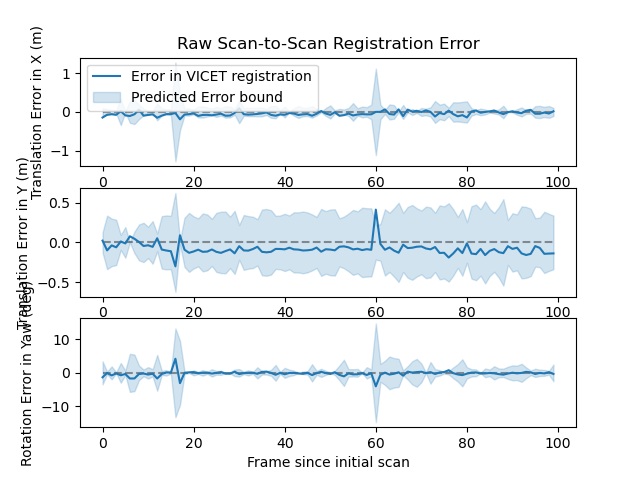

Text(0, 0.5, 'Rotation Error in Yaw (deg)')

In [68]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(3,1)
ax[0].set_title("Raw Scan-to-Scan Registration Error")
ax[0].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:,0], label = 'Error in VICET registration', color = 'C0')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,6]),
                y2 = -abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[0].set_xlabel("Frame since keyframe scan")
ax[0].set_ylabel("Translation Error in X (m)")
ax[0].legend(loc = 'best')

ax[1].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:,1], label = 'Error in VICET registration', color = "C0")
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,7]),
                y2 = -abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[1].set_xlabel("Frame since initial scan")
ax[1].set_ylabel("Translation Error in Y (m)")
# ax[1].legend(loc = 'best')

ax[2].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[2].plot(np.rad2deg(A_hist[:,5]), label = 'Error in VICET registration', color = "C0")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(np.rad2deg(A_hist[:,11])),
                y2 = -abs(np.rad2deg(A_hist[:,11])), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
ax[2].set_xlabel("Frame since initial scan")
ax[2].set_ylabel("Rotation Error in Yaw (deg)")
# ax[2].legend(loc = 'best')

# np.save("results/VICET/VICET_constant_keyframe_05_start_from_1800_v1", A_hist)

# compare with LOAM errors for frames 1800-1850 (moving start):

In [79]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

# fn = "results/LOAM/05_LOAM_start_from_1800_v1.npy"
fn = "results/LOAM/05_LOAM_start_from_1800_v2.npy"
# fn = "results/LOAM/05_LOAM_start_from_1790_v1.npy"# start_idx = 1789
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]
# LOAM_traj =  LOAM_traj[2:,:] - LOAM_traj[2,:] #might looks better??

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 1799 #1800 

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(50.25), np.deg2rad(0)]).as_matrix() #was this
# rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(46.5), np.deg2rad(0)]).as_matrix() #for 1790
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)

gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

A_hist = np.load('results/VICET/VICET_constant_keyframe_05_start_from_1800_v1.npy')

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Plot LOAM Odometry with VICET Error Bounds

<IPython.core.display.Javascript object>


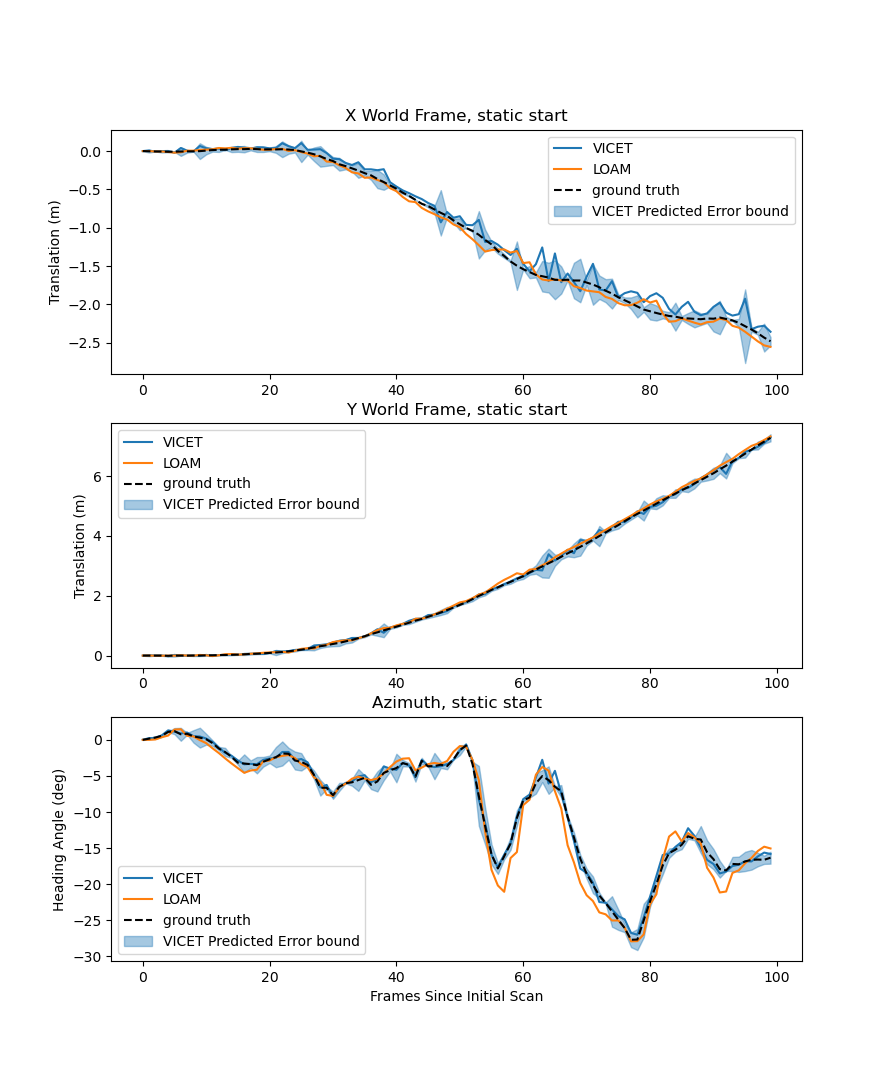

In [103]:
from matplotlib import pyplot as plt
# view_len = 50 #works best
view_len = len(A_hist) #show all data (need to comment out bounds)

fig,ax = plt.subplots(3,1)

# ax[0].set_title("X World Frame, moving start")
ax[0].set_title("X World Frame, static start")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0] + A_hist[:,0],
           label = 'VICET', color = 'C0')
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM', color = "C1")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], 'k--', label = 'ground truth')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = gt_lidarframe[start_idx:start_idx+view_len,0] + abs(A_hist[:,6]),
                y2 = gt_lidarframe[start_idx:start_idx+view_len,0] - abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='best')

# ax[1].set_title("Y World Frame, moving start")
ax[1].set_title("Y World Frame, static start")
ax[1].set_ylabel("Translation (m)")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1] + A_hist[:,1], label = 'VICET', color = 'C0')
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM', color = "C1")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], 'k--', label = 'ground truth')
ax[1].legend(loc='best')
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = gt_lidarframe[start_idx:start_idx+view_len,1] + abs(A_hist[:,7]),
                y2 = gt_lidarframe[start_idx:start_idx+view_len,1] - abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='best')

gt_euls = R.from_quat(qxyzw).as_euler('xyz')
# ax[2].set_title("Azimuth, moving start")
ax[2].set_title("Azimuth, static start")
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]) + np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2]), label = 'LOAM')
ax[2].plot(np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2] + A_hist[:,5]), label = 'VICET', color = "C0")
ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]), label = 'LOAM', color = "C1")
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]) - 1, label = 'LOAM') #debug
ax[2].plot(np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2]), 'k--', label = 'ground truth')
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Heading Angle (deg)")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] + abs(A_hist[:,11]) - gt_euls[start_idx,2]),
                y2 = np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - abs(A_hist[:,11]) - gt_euls[start_idx,2]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'best')

<IPython.core.display.Javascript object>


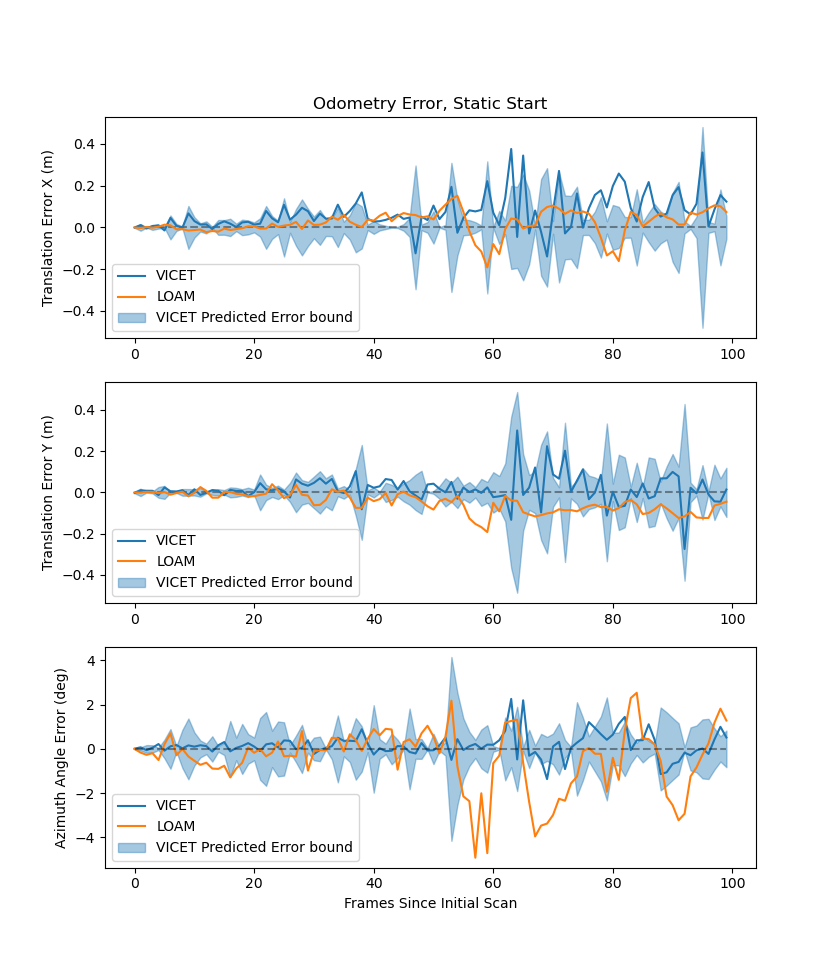

In [106]:
#plot error vs error bounds
from matplotlib import pyplot as plt
# view_len = 50 #works best
view_len = len(A_hist) #show all data

fig,ax = plt.subplots(3,1)
# ax[0].set_title("Odometry Error, Moving Start at Frame 1800")
ax[0].set_title("Odometry Error, Static Start")
ax[0].set_ylabel("Translation Error X (m)")
ax[0].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:,0], label = 'VICET', color = 'C0')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len, 0] - LOAM_corr[:view_len,0], label = 'LOAM', color='C1')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 =  abs(A_hist[:,6]),
                y2 = -abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='lower left')

# ax[1].set_title("Y Error, moving start")
ax[1].set_ylabel("Translation Error Y (m)")
ax[1].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:,1], label = 'VICET', color = 'C0')
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len, 1] - LOAM_corr[:view_len,1], label = 'LOAM', color='C1')
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,7]),
                y2 = -abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='lower left')
# ax[1].set_xlabel("Frames since Initial Scan")

gt_euls = R.from_quat(qxyzw).as_euler('xyz')
# ax[2].set_title("Azimuth  Error, moving start")
ax[2].plot(np.rad2deg(A_hist[:,5]), label = 'VICET', color = 'C0')
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]), label = 'LOAM', color = 'C1')
ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4] - gt_euls[start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')
ax[2].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Azimuth Angle Error (deg)")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = np.rad2deg(abs(A_hist[:,11])),
                y2 = np.rad2deg(-abs(A_hist[:,11])), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'lower left')

# compare LOAM vs VICET error bound on frames ~2020-2070 (static start):

In [100]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
fn = "results/LOAM/05_LOAM_start_from_static_v2.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:] #was this


LOAM_axis = np.eye(3)
# start_idx = 2010 #for new test (6/28)
start_idx = 2030 #better??
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix() #was this for 678
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(28), 0]).as_matrix() #test
rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(26), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #for test 678
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=3).legend("Actual Motion of Platform")
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#get VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #static start
VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v1.npy")
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2.npy")
A_hist = VICET_A_hist[:100,:]

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(190)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
# from matplotlib import pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(VICET_A_hist[:,6])